In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as k
import numpy as np
from scipy.stats import norm
from time import time
from sklearn.utils import shuffle

In [2]:

def blackScholesPriceTrue(fwd, strike, mat, vol):
    sqt = vol * np.sqrt(mat)
    d1 = (np.log(fwd / strike) + 0.5 * vol* vol * mat)/sqt
    d2 = d1 - sqt
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    return n1 - strike/fwd * n2

def createDataset(size):
    f = np.linspace(0.5,1.5, size)
    strike = np.linspace(0.5,1.5, size)
    T = np.linspace(0.1,1,size)
    vol = np.linspace(0.01, 0.5, size)
    inputs = np.array(np.meshgrid(f,strike,T,vol)).T.reshape(-1, 4)
    options = blackScholesPriceTrue(inputs[:,0],inputs[:,1], inputs[:,2], inputs[:,3])
    return inputs, options

class OptionsSequence(k.utils.Sequence):

    def __init__(self, dataSetSize, batch_size):
        x, y = createDataset(dataSetSize)
        self.x, self.y = shuffle(x,y, random_state=0)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size,:]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_y = shuffle(batch_x, batch_y, random_state=0)
        return batch_x, batch_y


In [12]:

def add_normalized_layer(h_units, activation='relu'):
    return [
        k.layers.Dense(h_units, use_bias=False),
        k.layers.BatchNormalization(),
        k.layers.Activation(activation)
            ]

def create_model(h_layers, h_units, modelFile = None):
    layers = [k.layers.Dense(units=h_units,  input_dim=4)]
    layers +=[k.layers.Dropout(rate=0.8)]
    for _ in range(h_layers):
        layers += add_normalized_layer(h_units)
    layers += [k.layers.Dense(units=1)]
    model = k.models.Sequential(layers)
    optimizer = k.optimizers.RMSprop(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    if modelFile is not None:
        try:
            model.load_weights(modelFile)
        except:
            pass
    return model


In [13]:

generator = OptionsSequence(10,200)
val_generator = OptionsSequence(5, 5**4)


In [14]:
modelFile = 'bsPricerModel.hdf5'
layers = 8
hidden_units = 256
model = create_model(layers, hidden_units, modelFile)

epochs = 100
checkpoint = k.callbacks.ModelCheckpoint(modelFile,monitor='val_loss')
#tensorboard = k.callbacks.TensorBoard(log_dir='LOGS\\{}'.format(time()), histogram_freq=1, write_graph=True)
reduce_lr = k.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model.fit_generator(generator=generator, epochs=epochs, validation_data=val_generator, validation_freq=1, 
                    workers=4, verbose=1, callbacks=[checkpoint, reduce_lr])


Epoch 1/100


 1/50 [..............................] - ETA: 5:01 - loss: 1.2319

 3/50 [>.............................] - ETA: 1:37 - loss: 1.5203

 5/50 [==>...........................] - ETA: 56s - loss: 1.0729 

 7/50 [===>..........................] - ETA: 38s - loss: 0.8402

 9/50 [====>.........................] - ETA: 29s - loss: 0.7095

11/50 [=====>........................] - ETA: 22s - loss: 0.6311

13/50 [======>.......................] - ETA: 18s - loss: 0.5746

15/50 [========>.....................] - ETA: 15s - loss: 0.5300

17/50 [=========>....................] - ETA: 12s - loss: 0.4910

19/50 [==========>...................] - ETA: 10s - loss: 0.4603

21/50 [===========>..................] - ETA: 9s - loss: 0.4365 

23/50 [============>.................] - ETA: 7s - loss: 0.4153



25/50 [==============>...............] - ETA: 6s - loss: 0.3971

27/50 [===============>..............] - ETA: 5s - loss: 0.3828

29/50 [================>.............] - ETA: 5s - loss: 0.3673

31/50 [=================>............] - ETA: 4s - loss: 0.3547

33/50 [==================>...........] - ETA: 3s - loss: 0.3456

35/50 [====================>.........] - ETA: 3s - loss: 0.3388

37/50 [=====================>........] - ETA: 2s - loss: 0.3313

39/50 [======================>.......] - ETA: 2s - loss: 0.3237

41/50 [=======================>......] - ETA: 1s - loss: 0.3167

43/50 [========================>.....] - ETA: 1s - loss: 0.3096

45/50 [==========================>...] - ETA: 0s - loss: 0.3040

47/50 [===========================>..] - ETA: 0s - loss: 0.2982

49/50 [============================>.] - ETA: 0s - loss: 0.2925

50/50 [==============================] - 17s 341ms/step - loss: 0.2900 - val_loss: 0.0491


Epoch 2/100
 1/50 [..............................] - ETA: 1s - loss: 0.2160

 3/50 [>.............................] - ETA: 1s - loss: 0.1588

 5/50 [==>...........................] - ETA: 1s - loss: 0.1462

 7/50 [===>..........................] - ETA: 1s - loss: 0.1413

 9/50 [====>.........................] - ETA: 1s - loss: 0.1490

11/50 [=====>........................] - ETA: 1s - loss: 0.1436

13/50 [======>.......................] - ETA: 1s - loss: 0.1408

15/50 [========>.....................] - ETA: 1s - loss: 0.1437

17/50 [=========>....................] - ETA: 0s - loss: 0.1503

19/50 [==========>...................] - ETA: 0s - loss: 0.1485

21/50 [===========>..................] - ETA: 0s - loss: 0.1455

23/50 [============>.................] - ETA: 0s - loss: 0.1429

25/50 [==============>...............] - ETA: 0s - loss: 0.1387

27/50 [===============>..............] - ETA: 0s - loss: 0.1358

29/50 [================>.............] - ETA: 0s - loss: 0.1337

31/50 [=================>............] - ETA: 0s - loss: 0.1337

33/50 [==================>...........] - ETA: 0s - loss: 0.1367

35/50 [====================>.........] - ETA: 0s - loss: 0.1364

37/50 [=====================>........] - ETA: 0s - loss: 0.1349

39/50 [======================>.......] - ETA: 0s - loss: 0.1327

41/50 [=======================>......] - ETA: 0s - loss: 0.1310

43/50 [========================>.....] - ETA: 0s - loss: 0.1290

45/50 [==========================>...] - ETA: 0s - loss: 0.1285

47/50 [===========================>..] - ETA: 0s - loss: 0.1273

49/50 [============================>.] - ETA: 0s - loss: 0.1283

50/50 [==============================] - 2s 34ms/step - loss: 0.1290 - val_loss: 0.0476


Epoch 3/100
 1/50 [..............................] - ETA: 1s - loss: 0.1153

 3/50 [>.............................] - ETA: 1s - loss: 0.0966

 5/50 [==>...........................] - ETA: 1s - loss: 0.0957

 7/50 [===>..........................] - ETA: 1s - loss: 0.0916

 9/50 [====>.........................] - ETA: 1s - loss: 0.0920

11/50 [=====>........................] - ETA: 1s - loss: 0.0987

13/50 [======>.......................] - ETA: 1s - loss: 0.0951

15/50 [========>.....................] - ETA: 1s - loss: 0.0932

17/50 [=========>....................] - ETA: 0s - loss: 0.0903

19/50 [==========>...................] - ETA: 0s - loss: 0.0908

21/50 [===========>..................] - ETA: 0s - loss: 0.0904

23/50 [============>.................] - ETA: 0s - loss: 0.0901

25/50 [==============>...............] - ETA: 0s - loss: 0.0900

27/50 [===============>..............] - ETA: 0s - loss: 0.0887

29/50 [================>.............] - ETA: 0s - loss: 0.0887

31/50 [=================>............] - ETA: 0s - loss: 0.0874

33/50 [==================>...........] - ETA: 0s - loss: 0.0862

35/50 [====================>.........] - ETA: 0s - loss: 0.0856

37/50 [=====================>........] - ETA: 0s - loss: 0.0852

39/50 [======================>.......] - ETA: 0s - loss: 0.0862

41/50 [=======================>......] - ETA: 0s - loss: 0.0873

43/50 [========================>.....] - ETA: 0s - loss: 0.0868

45/50 [==========================>...] - ETA: 0s - loss: 0.0851

47/50 [===========================>..] - ETA: 0s - loss: 0.0839

49/50 [============================>.] - ETA: 0s - loss: 0.0824

50/50 [==============================] - 2s 35ms/step - loss: 0.0817 - val_loss: 0.0393


Epoch 4/100
 1/50 [..............................] - ETA: 1s - loss: 0.0629

 3/50 [>.............................] - ETA: 1s - loss: 0.0746

 5/50 [==>...........................] - ETA: 1s - loss: 0.1042

 7/50 [===>..........................] - ETA: 1s - loss: 0.0972

 9/50 [====>.........................] - ETA: 1s - loss: 0.0855

11/50 [=====>........................] - ETA: 1s - loss: 0.0799

13/50 [======>.......................] - ETA: 1s - loss: 0.0760

15/50 [========>.....................] - ETA: 0s - loss: 0.0735

17/50 [=========>....................] - ETA: 0s - loss: 0.0795

19/50 [==========>...................] - ETA: 0s - loss: 0.0784

21/50 [===========>..................] - ETA: 0s - loss: 0.0771

23/50 [============>.................] - ETA: 0s - loss: 0.0736

25/50 [==============>...............] - ETA: 0s - loss: 0.0714

27/50 [===============>..............] - ETA: 0s - loss: 0.0710

29/50 [================>.............] - ETA: 0s - loss: 0.0723

31/50 [=================>............] - ETA: 0s - loss: 0.0721

33/50 [==================>...........] - ETA: 0s - loss: 0.0706

35/50 [====================>.........] - ETA: 0s - loss: 0.0704

37/50 [=====================>........] - ETA: 0s - loss: 0.0704

39/50 [======================>.......] - ETA: 0s - loss: 0.0686

41/50 [=======================>......] - ETA: 0s - loss: 0.0671

43/50 [========================>.....] - ETA: 0s - loss: 0.0661

45/50 [==========================>...] - ETA: 0s - loss: 0.0659

47/50 [===========================>..] - ETA: 0s - loss: 0.0660

49/50 [============================>.] - ETA: 0s - loss: 0.0679

50/50 [==============================] - 2s 34ms/step - loss: 0.0686 - val_loss: 0.0172


Epoch 5/100
 1/50 [..............................] - ETA: 1s - loss: 0.0499

 3/50 [>.............................] - ETA: 1s - loss: 0.0392

 5/50 [==>...........................] - ETA: 1s - loss: 0.0414

 7/50 [===>..........................] - ETA: 1s - loss: 0.0406

 9/50 [====>.........................] - ETA: 1s - loss: 0.0395

11/50 [=====>........................] - ETA: 1s - loss: 0.0391

13/50 [======>.......................] - ETA: 1s - loss: 0.0408

15/50 [========>.....................] - ETA: 1s - loss: 0.0507

17/50 [=========>....................] - ETA: 0s - loss: 0.0526

19/50 [==========>...................] - ETA: 0s - loss: 0.0518

21/50 [===========>..................] - ETA: 0s - loss: 0.0503

23/50 [============>.................] - ETA: 0s - loss: 0.0488

25/50 [==============>...............] - ETA: 0s - loss: 0.0493



27/50 [===============>..............] - ETA: 0s - loss: 0.0480

29/50 [================>.............] - ETA: 0s - loss: 0.0467

31/50 [=================>............] - ETA: 0s - loss: 0.0471

33/50 [==================>...........] - ETA: 0s - loss: 0.0485

35/50 [====================>.........] - ETA: 0s - loss: 0.0476

37/50 [=====================>........] - ETA: 0s - loss: 0.0473

39/50 [======================>.......] - ETA: 0s - loss: 0.0469

41/50 [=======================>......] - ETA: 0s - loss: 0.0459

43/50 [========================>.....] - ETA: 0s - loss: 0.0455

45/50 [==========================>...] - ETA: 0s - loss: 0.0455

47/50 [===========================>..] - ETA: 0s - loss: 0.0449

50/50 [==============================] - 2s 34ms/step - loss: 0.0441 - val_loss: 0.0222


Epoch 6/100
 1/50 [..............................] - ETA: 2s - loss: 0.0653

 3/50 [>.............................] - ETA: 1s - loss: 0.0609

 5/50 [==>...........................] - ETA: 1s - loss: 0.0505

 7/50 [===>..........................] - ETA: 1s - loss: 0.0437

 9/50 [====>.........................] - ETA: 1s - loss: 0.0406

11/50 [=====>........................] - ETA: 1s - loss: 0.0373

13/50 [======>.......................] - ETA: 1s - loss: 0.0360

15/50 [========>.....................] - ETA: 1s - loss: 0.0372

17/50 [=========>....................] - ETA: 0s - loss: 0.0399

19/50 [==========>...................] - ETA: 0s - loss: 0.0393

21/50 [===========>..................] - ETA: 0s - loss: 0.0383

23/50 [============>.................] - ETA: 0s - loss: 0.0376

25/50 [==============>...............] - ETA: 0s - loss: 0.0370

27/50 [===============>..............] - ETA: 0s - loss: 0.0353

29/50 [================>.............] - ETA: 0s - loss: 0.0343

31/50 [=================>............] - ETA: 0s - loss: 0.0338

33/50 [==================>...........] - ETA: 0s - loss: 0.0342

35/50 [====================>.........] - ETA: 0s - loss: 0.0335



38/50 [=====================>........] - ETA: 0s - loss: 0.0322

40/50 [=======================>......] - ETA: 0s - loss: 0.0320

42/50 [========================>.....] - ETA: 0s - loss: 0.0324

44/50 [=========================>....] - ETA: 0s - loss: 0.0326

46/50 [==========================>...] - ETA: 0s - loss: 0.0325

48/50 [===========================>..] - ETA: 0s - loss: 0.0318

50/50 [==============================] - 2s 35ms/step - loss: 0.0310 - val_loss: 0.0163


Epoch 7/100
 1/50 [..............................] - ETA: 1s - loss: 0.0217

 3/50 [>.............................] - ETA: 1s - loss: 0.0311

 5/50 [==>...........................] - ETA: 1s - loss: 0.0275

 7/50 [===>..........................] - ETA: 1s - loss: 0.0243

 9/50 [====>.........................] - ETA: 1s - loss: 0.0228

11/50 [=====>........................] - ETA: 1s - loss: 0.0242

13/50 [======>.......................] - ETA: 1s - loss: 0.0229

15/50 [========>.....................] - ETA: 0s - loss: 0.0215

17/50 [=========>....................] - ETA: 0s - loss: 0.0213

19/50 [==========>...................] - ETA: 0s - loss: 0.0208

21/50 [===========>..................] - ETA: 0s - loss: 0.0205

23/50 [============>.................] - ETA: 0s - loss: 0.0203

25/50 [==============>...............] - ETA: 0s - loss: 0.0204

27/50 [===============>..............] - ETA: 0s - loss: 0.0205

29/50 [================>.............] - ETA: 0s - loss: 0.0211

31/50 [=================>............] - ETA: 0s - loss: 0.0216

33/50 [==================>...........] - ETA: 0s - loss: 0.0211

35/50 [====================>.........] - ETA: 0s - loss: 0.0207

37/50 [=====================>........] - ETA: 0s - loss: 0.0200

39/50 [======================>.......] - ETA: 0s - loss: 0.0194

41/50 [=======================>......] - ETA: 0s - loss: 0.0189

43/50 [========================>.....] - ETA: 0s - loss: 0.0187

45/50 [==========================>...] - ETA: 0s - loss: 0.0185

47/50 [===========================>..] - ETA: 0s - loss: 0.0181

49/50 [============================>.] - ETA: 0s - loss: 0.0178

50/50 [==============================] - 2s 34ms/step - loss: 0.0179 - val_loss: 0.0615


Epoch 8/100
 1/50 [..............................] - ETA: 1s - loss: 0.0259

 3/50 [>.............................] - ETA: 1s - loss: 0.0217

 5/50 [==>...........................] - ETA: 1s - loss: 0.0161

 7/50 [===>..........................] - ETA: 1s - loss: 0.0135

 9/50 [====>.........................] - ETA: 1s - loss: 0.0139

11/50 [=====>........................] - ETA: 1s - loss: 0.0133

13/50 [======>.......................] - ETA: 1s - loss: 0.0138

15/50 [========>.....................] - ETA: 0s - loss: 0.0131

17/50 [=========>....................] - ETA: 0s - loss: 0.0137

19/50 [==========>...................] - ETA: 0s - loss: 0.0133

21/50 [===========>..................] - ETA: 0s - loss: 0.0125

23/50 [============>.................] - ETA: 0s - loss: 0.0120

25/50 [==============>...............] - ETA: 0s - loss: 0.0119

27/50 [===============>..............] - ETA: 0s - loss: 0.0120

29/50 [================>.............] - ETA: 0s - loss: 0.0118

31/50 [=================>............] - ETA: 0s - loss: 0.0115

33/50 [==================>...........] - ETA: 0s - loss: 0.0114

35/50 [====================>.........] - ETA: 0s - loss: 0.0110

38/50 [=====================>........] - ETA: 0s - loss: 0.0107

40/50 [=======================>......] - ETA: 0s - loss: 0.0105



42/50 [========================>.....] - ETA: 0s - loss: 0.0103

44/50 [=========================>....] - ETA: 0s - loss: 0.0100

46/50 [==========================>...] - ETA: 0s - loss: 0.0098

48/50 [===========================>..] - ETA: 0s - loss: 0.0098

50/50 [==============================] - 2s 35ms/step - loss: 0.0098 - val_loss: 0.0530


Epoch 9/100
 1/50 [..............................] - ETA: 1s - loss: 0.0122

 3/50 [>.............................] - ETA: 1s - loss: 0.0081

 5/50 [==>...........................] - ETA: 1s - loss: 0.0064

 7/50 [===>..........................] - ETA: 1s - loss: 0.0058

 9/50 [====>.........................] - ETA: 1s - loss: 0.0059

11/50 [=====>........................] - ETA: 1s - loss: 0.0071

13/50 [======>.......................] - ETA: 1s - loss: 0.0079

15/50 [========>.....................] - ETA: 0s - loss: 0.0075

17/50 [=========>....................] - ETA: 0s - loss: 0.0072

19/50 [==========>...................] - ETA: 0s - loss: 0.0071

21/50 [===========>..................] - ETA: 0s - loss: 0.0069

23/50 [============>.................] - ETA: 0s - loss: 0.0066

25/50 [==============>...............] - ETA: 0s - loss: 0.0063

27/50 [===============>..............] - ETA: 0s - loss: 0.0061

29/50 [================>.............] - ETA: 0s - loss: 0.0059

31/50 [=================>............] - ETA: 0s - loss: 0.0058

33/50 [==================>...........] - ETA: 0s - loss: 0.0058

35/50 [====================>.........] - ETA: 0s - loss: 0.0057

37/50 [=====================>........] - ETA: 0s - loss: 0.0058

39/50 [======================>.......] - ETA: 0s - loss: 0.0060

41/50 [=======================>......] - ETA: 0s - loss: 0.0060

43/50 [========================>.....] - ETA: 0s - loss: 0.0058

45/50 [==========================>...] - ETA: 0s - loss: 0.0057

47/50 [===========================>..] - ETA: 0s - loss: 0.0056

49/50 [============================>.] - ETA: 0s - loss: 0.0055

50/50 [==============================] - 2s 35ms/step - loss: 0.0055 - val_loss: 0.0257


Epoch 10/100
 1/50 [..............................] - ETA: 1s - loss: 0.0030

 3/50 [>.............................] - ETA: 1s - loss: 0.0038

 5/50 [==>...........................] - ETA: 1s - loss: 0.0070

 7/50 [===>..........................] - ETA: 1s - loss: 0.0065

 9/50 [====>.........................] - ETA: 1s - loss: 0.0058

11/50 [=====>........................] - ETA: 1s - loss: 0.0053

13/50 [======>.......................] - ETA: 1s - loss: 0.0049

15/50 [========>.....................] - ETA: 0s - loss: 0.0047

17/50 [=========>....................] - ETA: 0s - loss: 0.0046

20/50 [===========>..................] - ETA: 0s - loss: 0.0053

22/50 [============>.................] - ETA: 0s - loss: 0.0053

24/50 [=============>................] - ETA: 0s - loss: 0.0051

26/50 [==============>...............] - ETA: 0s - loss: 0.0057

28/50 [===============>..............] - ETA: 0s - loss: 0.0058

30/50 [=================>............] - ETA: 0s - loss: 0.0056

32/50 [==================>...........] - ETA: 0s - loss: 0.0054

34/50 [===================>..........] - ETA: 0s - loss: 0.0053

36/50 [====================>.........] - ETA: 0s - loss: 0.0053

38/50 [=====================>........] - ETA: 0s - loss: 0.0053

40/50 [=======================>......] - ETA: 0s - loss: 0.0052

42/50 [========================>.....] - ETA: 0s - loss: 0.0052

45/50 [==========================>...] - ETA: 0s - loss: 0.0051

47/50 [===========================>..] - ETA: 0s - loss: 0.0050

49/50 [============================>.] - ETA: 0s - loss: 0.0051

50/50 [==============================] - 2s 35ms/step - loss: 0.0051 - val_loss: 0.0298


Epoch 11/100
 1/50 [..............................] - ETA: 2s - loss: 0.0053

 3/50 [>.............................] - ETA: 1s - loss: 0.0039

 5/50 [==>...........................] - ETA: 1s - loss: 0.0036

 7/50 [===>..........................] - ETA: 1s - loss: 0.0034

 9/50 [====>.........................] - ETA: 1s - loss: 0.0041

11/50 [=====>........................] - ETA: 1s - loss: 0.0045

13/50 [======>.......................] - ETA: 1s - loss: 0.0045

15/50 [========>.....................] - ETA: 1s - loss: 0.0045

17/50 [=========>....................] - ETA: 0s - loss: 0.0050

19/50 [==========>...................] - ETA: 0s - loss: 0.0048

21/50 [===========>..................] - ETA: 0s - loss: 0.0045

23/50 [============>.................] - ETA: 0s - loss: 0.0043

25/50 [==============>...............] - ETA: 0s - loss: 0.0042

27/50 [===============>..............] - ETA: 0s - loss: 0.0041

29/50 [================>.............] - ETA: 0s - loss: 0.0043

31/50 [=================>............] - ETA: 0s - loss: 0.0043

33/50 [==================>...........] - ETA: 0s - loss: 0.0042

35/50 [====================>.........] - ETA: 0s - loss: 0.0040

37/50 [=====================>........] - ETA: 0s - loss: 0.0041

39/50 [======================>.......] - ETA: 0s - loss: 0.0039

41/50 [=======================>......] - ETA: 0s - loss: 0.0039

43/50 [========================>.....] - ETA: 0s - loss: 0.0039

45/50 [==========================>...] - ETA: 0s - loss: 0.0040

47/50 [===========================>..] - ETA: 0s - loss: 0.0042

49/50 [============================>.] - ETA: 0s - loss: 0.0041

50/50 [==============================] - 3s 53ms/step - loss: 0.0041 - val_loss: 0.0583


Epoch 12/100
 1/50 [..............................] - ETA: 1s - loss: 0.0016

 3/50 [>.............................] - ETA: 1s - loss: 0.0017

 5/50 [==>...........................] - ETA: 1s - loss: 0.0016

 7/50 [===>..........................] - ETA: 1s - loss: 0.0016

 9/50 [====>.........................] - ETA: 1s - loss: 0.0016

11/50 [=====>........................] - ETA: 1s - loss: 0.0016

13/50 [======>.......................] - ETA: 1s - loss: 0.0017

15/50 [========>.....................] - ETA: 1s - loss: 0.0017

17/50 [=========>....................] - ETA: 0s - loss: 0.0017

19/50 [==========>...................] - ETA: 0s - loss: 0.0017

21/50 [===========>..................] - ETA: 0s - loss: 0.0017

23/50 [============>.................] - ETA: 0s - loss: 0.0017

25/50 [==============>...............] - ETA: 0s - loss: 0.0017

27/50 [===============>..............] - ETA: 0s - loss: 0.0017

29/50 [================>.............] - ETA: 0s - loss: 0.0017

31/50 [=================>............] - ETA: 0s - loss: 0.0017

33/50 [==================>...........] - ETA: 0s - loss: 0.0016

35/50 [====================>.........] - ETA: 0s - loss: 0.0016

37/50 [=====================>........] - ETA: 0s - loss: 0.0016

39/50 [======================>.......] - ETA: 0s - loss: 0.0016

41/50 [=======================>......] - ETA: 0s - loss: 0.0018

43/50 [========================>.....] - ETA: 0s - loss: 0.0018

45/50 [==========================>...] - ETA: 0s - loss: 0.0018

47/50 [===========================>..] - ETA: 0s - loss: 0.0018

49/50 [============================>.] - ETA: 0s - loss: 0.0018

50/50 [==============================] - 2s 35ms/step - loss: 0.0018 - val_loss: 0.0160


Epoch 13/100
 1/50 [..............................] - ETA: 1s - loss: 0.0011

 3/50 [>.............................] - ETA: 1s - loss: 0.0015

 5/50 [==>...........................] - ETA: 1s - loss: 0.0014

 7/50 [===>..........................] - ETA: 1s - loss: 0.0014

 9/50 [====>.........................] - ETA: 1s - loss: 0.0013

11/50 [=====>........................] - ETA: 1s - loss: 0.0014

13/50 [======>.......................] - ETA: 1s - loss: 0.0014

15/50 [========>.....................] - ETA: 0s - loss: 0.0017

17/50 [=========>....................] - ETA: 0s - loss: 0.0017

19/50 [==========>...................] - ETA: 0s - loss: 0.0017

21/50 [===========>..................] - ETA: 0s - loss: 0.0016

23/50 [============>.................] - ETA: 0s - loss: 0.0017

25/50 [==============>...............] - ETA: 0s - loss: 0.0016

27/50 [===============>..............] - ETA: 0s - loss: 0.0016

29/50 [================>.............] - ETA: 0s - loss: 0.0016

31/50 [=================>............] - ETA: 0s - loss: 0.0016

33/50 [==================>...........] - ETA: 0s - loss: 0.0016

35/50 [====================>.........] - ETA: 0s - loss: 0.0016

37/50 [=====================>........] - ETA: 0s - loss: 0.0016

39/50 [======================>.......] - ETA: 0s - loss: 0.0016

41/50 [=======================>......] - ETA: 0s - loss: 0.0016

43/50 [========================>.....] - ETA: 0s - loss: 0.0016

45/50 [==========================>...] - ETA: 0s - loss: 0.0016

47/50 [===========================>..] - ETA: 0s - loss: 0.0017

49/50 [============================>.] - ETA: 0s - loss: 0.0017

50/50 [==============================] - 2s 36ms/step - loss: 0.0017 - val_loss: 0.0092


Epoch 14/100
 1/50 [..............................] - ETA: 1s - loss: 0.0013

 3/50 [>.............................] - ETA: 1s - loss: 0.0016

 5/50 [==>...........................] - ETA: 1s - loss: 0.0016

 7/50 [===>..........................] - ETA: 1s - loss: 0.0015

 9/50 [====>.........................] - ETA: 1s - loss: 0.0015

11/50 [=====>........................] - ETA: 1s - loss: 0.0014

13/50 [======>.......................] - ETA: 1s - loss: 0.0015

15/50 [========>.....................] - ETA: 0s - loss: 0.0015

17/50 [=========>....................] - ETA: 0s - loss: 0.0015

19/50 [==========>...................] - ETA: 0s - loss: 0.0015

21/50 [===========>..................] - ETA: 0s - loss: 0.0016

24/50 [=============>................] - ETA: 0s - loss: 0.0016

26/50 [==============>...............] - ETA: 0s - loss: 0.0016

28/50 [===============>..............] - ETA: 0s - loss: 0.0016

30/50 [=================>............] - ETA: 0s - loss: 0.0016

32/50 [==================>...........] - ETA: 0s - loss: 0.0016

34/50 [===================>..........] - ETA: 0s - loss: 0.0016

36/50 [====================>.........] - ETA: 0s - loss: 0.0016

38/50 [=====================>........] - ETA: 0s - loss: 0.0016

40/50 [=======================>......] - ETA: 0s - loss: 0.0015

42/50 [========================>.....] - ETA: 0s - loss: 0.0016

44/50 [=========================>....] - ETA: 0s - loss: 0.0016

46/50 [==========================>...] - ETA: 0s - loss: 0.0017

48/50 [===========================>..] - ETA: 0s - loss: 0.0016

50/50 [==============================] - 2s 34ms/step - loss: 0.0016 - val_loss: 0.0054


Epoch 15/100
 1/50 [..............................] - ETA: 1s - loss: 0.0017

 3/50 [>.............................] - ETA: 1s - loss: 0.0015

 5/50 [==>...........................] - ETA: 1s - loss: 0.0017

 7/50 [===>..........................] - ETA: 1s - loss: 0.0017

 9/50 [====>.........................] - ETA: 1s - loss: 0.0016

11/50 [=====>........................] - ETA: 1s - loss: 0.0016

13/50 [======>.......................] - ETA: 1s - loss: 0.0016

15/50 [========>.....................] - ETA: 1s - loss: 0.0015

17/50 [=========>....................] - ETA: 0s - loss: 0.0016

19/50 [==========>...................] - ETA: 0s - loss: 0.0016

21/50 [===========>..................] - ETA: 0s - loss: 0.0016

23/50 [============>.................] - ETA: 0s - loss: 0.0015

25/50 [==============>...............] - ETA: 0s - loss: 0.0015

27/50 [===============>..............] - ETA: 0s - loss: 0.0015

29/50 [================>.............] - ETA: 0s - loss: 0.0015

31/50 [=================>............] - ETA: 0s - loss: 0.0015

33/50 [==================>...........] - ETA: 0s - loss: 0.0015

35/50 [====================>.........] - ETA: 0s - loss: 0.0015

37/50 [=====================>........] - ETA: 0s - loss: 0.0015

39/50 [======================>.......] - ETA: 0s - loss: 0.0015

41/50 [=======================>......] - ETA: 0s - loss: 0.0015

43/50 [========================>.....] - ETA: 0s - loss: 0.0015

45/50 [==========================>...] - ETA: 0s - loss: 0.0015

47/50 [===========================>..] - ETA: 0s - loss: 0.0015

49/50 [============================>.] - ETA: 0s - loss: 0.0015

50/50 [==============================] - 2s 36ms/step - loss: 0.0016 - val_loss: 0.0033


Epoch 16/100
 1/50 [..............................] - ETA: 1s - loss: 0.0015

 3/50 [>.............................] - ETA: 1s - loss: 0.0015

 5/50 [==>...........................] - ETA: 1s - loss: 0.0016

 7/50 [===>..........................] - ETA: 1s - loss: 0.0014

 9/50 [====>.........................] - ETA: 1s - loss: 0.0014

11/50 [=====>........................] - ETA: 1s - loss: 0.0014

13/50 [======>.......................] - ETA: 1s - loss: 0.0015

15/50 [========>.....................] - ETA: 1s - loss: 0.0014

17/50 [=========>....................] - ETA: 0s - loss: 0.0014

19/50 [==========>...................] - ETA: 0s - loss: 0.0014

21/50 [===========>..................] - ETA: 0s - loss: 0.0015

23/50 [============>.................] - ETA: 0s - loss: 0.0014

25/50 [==============>...............] - ETA: 0s - loss: 0.0014

27/50 [===============>..............] - ETA: 0s - loss: 0.0015

29/50 [================>.............] - ETA: 0s - loss: 0.0015

31/50 [=================>............] - ETA: 0s - loss: 0.0015



34/50 [===================>..........] - ETA: 0s - loss: 0.0015



36/50 [====================>.........] - ETA: 0s - loss: 0.0015



38/50 [=====================>........] - ETA: 0s - loss: 0.0015

40/50 [=======================>......] - ETA: 0s - loss: 0.0015

42/50 [========================>.....] - ETA: 0s - loss: 0.0015

44/50 [=========================>....] - ETA: 0s - loss: 0.0015

46/50 [==========================>...] - ETA: 0s - loss: 0.0015

48/50 [===========================>..] - ETA: 0s - loss: 0.0015

50/50 [==============================] - 2s 35ms/step - loss: 0.0015 - val_loss: 0.0026


Epoch 17/100
 1/50 [..............................] - ETA: 1s - loss: 0.0012

 3/50 [>.............................] - ETA: 1s - loss: 0.0012

 5/50 [==>...........................] - ETA: 1s - loss: 0.0014



 7/50 [===>..........................] - ETA: 1s - loss: 0.0013

 9/50 [====>.........................] - ETA: 1s - loss: 0.0013

11/50 [=====>........................] - ETA: 1s - loss: 0.0016

13/50 [======>.......................] - ETA: 1s - loss: 0.0015

15/50 [========>.....................] - ETA: 0s - loss: 0.0015

17/50 [=========>....................] - ETA: 0s - loss: 0.0015

19/50 [==========>...................] - ETA: 0s - loss: 0.0015

21/50 [===========>..................] - ETA: 0s - loss: 0.0014

23/50 [============>.................] - ETA: 0s - loss: 0.0014

25/50 [==============>...............] - ETA: 0s - loss: 0.0014

27/50 [===============>..............] - ETA: 0s - loss: 0.0014

29/50 [================>.............] - ETA: 0s - loss: 0.0014

31/50 [=================>............] - ETA: 0s - loss: 0.0014

33/50 [==================>...........] - ETA: 0s - loss: 0.0014

35/50 [====================>.........] - ETA: 0s - loss: 0.0014

37/50 [=====================>........] - ETA: 0s - loss: 0.0014

39/50 [======================>.......] - ETA: 0s - loss: 0.0014

41/50 [=======================>......] - ETA: 0s - loss: 0.0014

43/50 [========================>.....] - ETA: 0s - loss: 0.0014

45/50 [==========================>...] - ETA: 0s - loss: 0.0015

47/50 [===========================>..] - ETA: 0s - loss: 0.0015

49/50 [============================>.] - ETA: 0s - loss: 0.0014

50/50 [==============================] - 2s 35ms/step - loss: 0.0015 - val_loss: 0.0030


Epoch 18/100
 1/50 [..............................] - ETA: 1s - loss: 0.0017

 3/50 [>.............................] - ETA: 1s - loss: 0.0013

 5/50 [==>...........................] - ETA: 1s - loss: 0.0012

 7/50 [===>..........................] - ETA: 1s - loss: 0.0012

 9/50 [====>.........................] - ETA: 1s - loss: 0.0013

11/50 [=====>........................] - ETA: 1s - loss: 0.0013

13/50 [======>.......................] - ETA: 1s - loss: 0.0013

15/50 [========>.....................] - ETA: 1s - loss: 0.0013

17/50 [=========>....................] - ETA: 0s - loss: 0.0014

19/50 [==========>...................] - ETA: 0s - loss: 0.0014

21/50 [===========>..................] - ETA: 0s - loss: 0.0014

23/50 [============>.................] - ETA: 0s - loss: 0.0014

25/50 [==============>...............] - ETA: 0s - loss: 0.0014

27/50 [===============>..............] - ETA: 0s - loss: 0.0015

29/50 [================>.............] - ETA: 0s - loss: 0.0015

31/50 [=================>............] - ETA: 0s - loss: 0.0015

33/50 [==================>...........] - ETA: 0s - loss: 0.0016

35/50 [====================>.........] - ETA: 0s - loss: 0.0016

37/50 [=====================>........] - ETA: 0s - loss: 0.0016

39/50 [======================>.......] - ETA: 0s - loss: 0.0015

41/50 [=======================>......] - ETA: 0s - loss: 0.0015

43/50 [========================>.....] - ETA: 0s - loss: 0.0015

45/50 [==========================>...] - ETA: 0s - loss: 0.0015

47/50 [===========================>..] - ETA: 0s - loss: 0.0015

49/50 [============================>.] - ETA: 0s - loss: 0.0015

50/50 [==============================] - 2s 36ms/step - loss: 0.0015 - val_loss: 0.0024


Epoch 19/100
 1/50 [..............................] - ETA: 1s - loss: 0.0011

 3/50 [>.............................] - ETA: 1s - loss: 0.0014

 5/50 [==>...........................] - ETA: 1s - loss: 0.0015

 7/50 [===>..........................] - ETA: 1s - loss: 0.0015

 9/50 [====>.........................] - ETA: 1s - loss: 0.0014

11/50 [=====>........................] - ETA: 1s - loss: 0.0013

13/50 [======>.......................] - ETA: 1s - loss: 0.0015

15/50 [========>.....................] - ETA: 0s - loss: 0.0015

17/50 [=========>....................] - ETA: 0s - loss: 0.0014

19/50 [==========>...................] - ETA: 0s - loss: 0.0014

21/50 [===========>..................] - ETA: 0s - loss: 0.0014

23/50 [============>.................] - ETA: 0s - loss: 0.0014

25/50 [==============>...............] - ETA: 0s - loss: 0.0014

27/50 [===============>..............] - ETA: 0s - loss: 0.0014

30/50 [=================>............] - ETA: 0s - loss: 0.0014

33/50 [==================>...........] - ETA: 0s - loss: 0.0013

35/50 [====================>.........] - ETA: 0s - loss: 0.0014

37/50 [=====================>........] - ETA: 0s - loss: 0.0014

39/50 [======================>.......] - ETA: 0s - loss: 0.0013

41/50 [=======================>......] - ETA: 0s - loss: 0.0013

43/50 [========================>.....] - ETA: 0s - loss: 0.0014

45/50 [==========================>...] - ETA: 0s - loss: 0.0014

47/50 [===========================>..] - ETA: 0s - loss: 0.0014

49/50 [============================>.] - ETA: 0s - loss: 0.0014

50/50 [==============================] - 2s 34ms/step - loss: 0.0014 - val_loss: 0.0021


Epoch 20/100
 1/50 [..............................] - ETA: 1s - loss: 0.0013

 3/50 [>.............................] - ETA: 1s - loss: 0.0014

 5/50 [==>...........................] - ETA: 1s - loss: 0.0015

 7/50 [===>..........................] - ETA: 1s - loss: 0.0014

 9/50 [====>.........................] - ETA: 1s - loss: 0.0013

11/50 [=====>........................] - ETA: 1s - loss: 0.0013

13/50 [======>.......................] - ETA: 1s - loss: 0.0012

15/50 [========>.....................] - ETA: 1s - loss: 0.0012

17/50 [=========>....................] - ETA: 0s - loss: 0.0013

19/50 [==========>...................] - ETA: 0s - loss: 0.0012

21/50 [===========>..................] - ETA: 0s - loss: 0.0013

23/50 [============>.................] - ETA: 0s - loss: 0.0013

25/50 [==============>...............] - ETA: 0s - loss: 0.0013

27/50 [===============>..............] - ETA: 0s - loss: 0.0013

29/50 [================>.............] - ETA: 0s - loss: 0.0013

31/50 [=================>............] - ETA: 0s - loss: 0.0013

33/50 [==================>...........] - ETA: 0s - loss: 0.0013

35/50 [====================>.........] - ETA: 0s - loss: 0.0013

37/50 [=====================>........] - ETA: 0s - loss: 0.0013

39/50 [======================>.......] - ETA: 0s - loss: 0.0014

41/50 [=======================>......] - ETA: 0s - loss: 0.0014

43/50 [========================>.....] - ETA: 0s - loss: 0.0014

45/50 [==========================>...] - ETA: 0s - loss: 0.0014

47/50 [===========================>..] - ETA: 0s - loss: 0.0014

50/50 [==============================] - 2s 35ms/step - loss: 0.0014 - val_loss: 0.0025


Epoch 21/100
 1/50 [..............................] - ETA: 1s - loss: 0.0017

 3/50 [>.............................] - ETA: 1s - loss: 0.0013

 5/50 [==>...........................] - ETA: 1s - loss: 0.0016

 7/50 [===>..........................] - ETA: 1s - loss: 0.0019

 9/50 [====>.........................] - ETA: 1s - loss: 0.0017

11/50 [=====>........................] - ETA: 1s - loss: 0.0017

14/50 [=======>......................] - ETA: 1s - loss: 0.0017

16/50 [========>.....................] - ETA: 0s - loss: 0.0016

18/50 [=========>....................] - ETA: 0s - loss: 0.0016

20/50 [===========>..................] - ETA: 0s - loss: 0.0015

22/50 [============>.................] - ETA: 0s - loss: 0.0015

24/50 [=============>................] - ETA: 0s - loss: 0.0015

26/50 [==============>...............] - ETA: 0s - loss: 0.0015

28/50 [===============>..............] - ETA: 0s - loss: 0.0015

30/50 [=================>............] - ETA: 0s - loss: 0.0015

32/50 [==================>...........] - ETA: 0s - loss: 0.0014

34/50 [===================>..........] - ETA: 0s - loss: 0.0015

36/50 [====================>.........] - ETA: 0s - loss: 0.0014

38/50 [=====================>........] - ETA: 0s - loss: 0.0014

40/50 [=======================>......] - ETA: 0s - loss: 0.0014

42/50 [========================>.....] - ETA: 0s - loss: 0.0014

44/50 [=========================>....] - ETA: 0s - loss: 0.0014

46/50 [==========================>...] - ETA: 0s - loss: 0.0014

48/50 [===========================>..] - ETA: 0s - loss: 0.0014

50/50 [==============================] - 2s 35ms/step - loss: 0.0014 - val_loss: 0.0020


Epoch 22/100
 1/50 [..............................] - ETA: 1s - loss: 0.0014

 3/50 [>.............................] - ETA: 1s - loss: 0.0012

 5/50 [==>...........................] - ETA: 1s - loss: 0.0011

 7/50 [===>..........................] - ETA: 1s - loss: 0.0020

 9/50 [====>.........................] - ETA: 1s - loss: 0.0018

11/50 [=====>........................] - ETA: 1s - loss: 0.0017

13/50 [======>.......................] - ETA: 1s - loss: 0.0015

15/50 [========>.....................] - ETA: 1s - loss: 0.0016

17/50 [=========>....................] - ETA: 0s - loss: 0.0015

19/50 [==========>...................] - ETA: 0s - loss: 0.0015

21/50 [===========>..................] - ETA: 0s - loss: 0.0015

23/50 [============>.................] - ETA: 0s - loss: 0.0014

25/50 [==============>...............] - ETA: 0s - loss: 0.0014

27/50 [===============>..............] - ETA: 0s - loss: 0.0014

29/50 [================>.............] - ETA: 0s - loss: 0.0014

31/50 [=================>............] - ETA: 0s - loss: 0.0014

33/50 [==================>...........] - ETA: 0s - loss: 0.0014

35/50 [====================>.........] - ETA: 0s - loss: 0.0013

37/50 [=====================>........] - ETA: 0s - loss: 0.0013

39/50 [======================>.......] - ETA: 0s - loss: 0.0013

41/50 [=======================>......] - ETA: 0s - loss: 0.0013

43/50 [========================>.....] - ETA: 0s - loss: 0.0013

45/50 [==========================>...] - ETA: 0s - loss: 0.0013

47/50 [===========================>..] - ETA: 0s - loss: 0.0013

49/50 [============================>.] - ETA: 0s - loss: 0.0014

50/50 [==============================] - 2s 35ms/step - loss: 0.0013 - val_loss: 0.0018


Epoch 23/100
 1/50 [..............................] - ETA: 1s - loss: 0.0013

 3/50 [>.............................] - ETA: 1s - loss: 0.0011

 5/50 [==>...........................] - ETA: 1s - loss: 0.0011

 7/50 [===>..........................] - ETA: 1s - loss: 0.0012

 9/50 [====>.........................] - ETA: 1s - loss: 0.0012

11/50 [=====>........................] - ETA: 1s - loss: 0.0012



13/50 [======>.......................] - ETA: 1s - loss: 0.0012



15/50 [========>.....................] - ETA: 1s - loss: 0.0011

17/50 [=========>....................] - ETA: 0s - loss: 0.0013

19/50 [==========>...................] - ETA: 0s - loss: 0.0013

21/50 [===========>..................] - ETA: 0s - loss: 0.0013

23/50 [============>.................] - ETA: 0s - loss: 0.0013

25/50 [==============>...............] - ETA: 0s - loss: 0.0013

27/50 [===============>..............] - ETA: 0s - loss: 0.0013

29/50 [================>.............] - ETA: 0s - loss: 0.0013

31/50 [=================>............] - ETA: 0s - loss: 0.0013

34/50 [===================>..........] - ETA: 0s - loss: 0.0013

36/50 [====================>.........] - ETA: 0s - loss: 0.0013

38/50 [=====================>........] - ETA: 0s - loss: 0.0013

40/50 [=======================>......] - ETA: 0s - loss: 0.0013

42/50 [========================>.....] - ETA: 0s - loss: 0.0013

44/50 [=========================>....] - ETA: 0s - loss: 0.0013

46/50 [==========================>...] - ETA: 0s - loss: 0.0013

48/50 [===========================>..] - ETA: 0s - loss: 0.0013

50/50 [==============================] - 2s 36ms/step - loss: 0.0013 - val_loss: 0.0022


Epoch 24/100
 1/50 [..............................] - ETA: 1s - loss: 9.6494e-04

 3/50 [>.............................] - ETA: 1s - loss: 0.0012    

 5/50 [==>...........................] - ETA: 1s - loss: 0.0011

 7/50 [===>..........................] - ETA: 1s - loss: 0.0011

 9/50 [====>.........................] - ETA: 1s - loss: 0.0011

11/50 [=====>........................] - ETA: 1s - loss: 0.0011

13/50 [======>.......................] - ETA: 1s - loss: 0.0011

15/50 [========>.....................] - ETA: 0s - loss: 0.0011

17/50 [=========>....................] - ETA: 0s - loss: 0.0012

19/50 [==========>...................] - ETA: 0s - loss: 0.0013

21/50 [===========>..................] - ETA: 0s - loss: 0.0012

23/50 [============>.................] - ETA: 0s - loss: 0.0012

25/50 [==============>...............] - ETA: 0s - loss: 0.0012

27/50 [===============>..............] - ETA: 0s - loss: 0.0012

29/50 [================>.............] - ETA: 0s - loss: 0.0012

31/50 [=================>............] - ETA: 0s - loss: 0.0012

33/50 [==================>...........] - ETA: 0s - loss: 0.0012

36/50 [====================>.........] - ETA: 0s - loss: 0.0012

38/50 [=====================>........] - ETA: 0s - loss: 0.0012

40/50 [=======================>......] - ETA: 0s - loss: 0.0012

42/50 [========================>.....] - ETA: 0s - loss: 0.0012

44/50 [=========================>....] - ETA: 0s - loss: 0.0012

46/50 [==========================>...] - ETA: 0s - loss: 0.0012

48/50 [===========================>..] - ETA: 0s - loss: 0.0013

50/50 [==============================] - 2s 34ms/step - loss: 0.0013 - val_loss: 0.0015


Epoch 25/100
 1/50 [..............................] - ETA: 1s - loss: 0.0011

 3/50 [>.............................] - ETA: 1s - loss: 0.0013

 5/50 [==>...........................] - ETA: 1s - loss: 0.0012

 7/50 [===>..........................] - ETA: 1s - loss: 0.0014

 9/50 [====>.........................] - ETA: 1s - loss: 0.0014

11/50 [=====>........................] - ETA: 1s - loss: 0.0013

13/50 [======>.......................] - ETA: 1s - loss: 0.0013

15/50 [========>.....................] - ETA: 1s - loss: 0.0013

17/50 [=========>....................] - ETA: 0s - loss: 0.0013

19/50 [==========>...................] - ETA: 0s - loss: 0.0014

21/50 [===========>..................] - ETA: 0s - loss: 0.0013

23/50 [============>.................] - ETA: 0s - loss: 0.0013

25/50 [==============>...............] - ETA: 0s - loss: 0.0013

27/50 [===============>..............] - ETA: 0s - loss: 0.0013

29/50 [================>.............] - ETA: 0s - loss: 0.0013

31/50 [=================>............] - ETA: 0s - loss: 0.0013

33/50 [==================>...........] - ETA: 0s - loss: 0.0013

35/50 [====================>.........] - ETA: 0s - loss: 0.0012

37/50 [=====================>........] - ETA: 0s - loss: 0.0012

39/50 [======================>.......] - ETA: 0s - loss: 0.0012

41/50 [=======================>......] - ETA: 0s - loss: 0.0012

44/50 [=========================>....] - ETA: 0s - loss: 0.0012

46/50 [==========================>...] - ETA: 0s - loss: 0.0012

48/50 [===========================>..] - ETA: 0s - loss: 0.0012

50/50 [==============================] - 2s 35ms/step - loss: 0.0012 - val_loss: 0.0012


Epoch 26/100
 1/50 [..............................] - ETA: 1s - loss: 8.7056e-04

 3/50 [>.............................] - ETA: 1s - loss: 8.8244e-04

 5/50 [==>...........................] - ETA: 1s - loss: 0.0011    

 7/50 [===>..........................] - ETA: 1s - loss: 0.0011

 9/50 [====>.........................] - ETA: 1s - loss: 0.0010

11/50 [=====>........................] - ETA: 1s - loss: 9.9728e-04

13/50 [======>.......................] - ETA: 1s - loss: 9.9259e-04

15/50 [========>.....................] - ETA: 0s - loss: 9.8053e-04

17/50 [=========>....................] - ETA: 0s - loss: 9.6310e-04

19/50 [==========>...................] - ETA: 0s - loss: 0.0010    

21/50 [===========>..................] - ETA: 0s - loss: 0.0011

23/50 [============>.................] - ETA: 0s - loss: 0.0011

25/50 [==============>...............] - ETA: 0s - loss: 0.0012

27/50 [===============>..............] - ETA: 0s - loss: 0.0012

29/50 [================>.............] - ETA: 0s - loss: 0.0012

31/50 [=================>............] - ETA: 0s - loss: 0.0012

33/50 [==================>...........] - ETA: 0s - loss: 0.0012

35/50 [====================>.........] - ETA: 0s - loss: 0.0012

37/50 [=====================>........] - ETA: 0s - loss: 0.0012

39/50 [======================>.......] - ETA: 0s - loss: 0.0012

41/50 [=======================>......] - ETA: 0s - loss: 0.0012

43/50 [========================>.....] - ETA: 0s - loss: 0.0012

45/50 [==========================>...] - ETA: 0s - loss: 0.0013

47/50 [===========================>..] - ETA: 0s - loss: 0.0013

49/50 [============================>.] - ETA: 0s - loss: 0.0012

50/50 [==============================] - 2s 34ms/step - loss: 0.0012 - val_loss: 0.0013


Epoch 27/100
 1/50 [..............................] - ETA: 1s - loss: 8.0521e-04

 3/50 [>.............................] - ETA: 1s - loss: 0.0015    

 5/50 [==>...........................] - ETA: 1s - loss: 0.0012

 7/50 [===>..........................] - ETA: 1s - loss: 0.0012

 9/50 [====>.........................] - ETA: 1s - loss: 0.0012

11/50 [=====>........................] - ETA: 1s - loss: 0.0011

13/50 [======>.......................] - ETA: 1s - loss: 0.0011

15/50 [========>.....................] - ETA: 1s - loss: 0.0012

17/50 [=========>....................] - ETA: 0s - loss: 0.0011

19/50 [==========>...................] - ETA: 0s - loss: 0.0011

21/50 [===========>..................] - ETA: 0s - loss: 0.0011

23/50 [============>.................] - ETA: 0s - loss: 0.0011

25/50 [==============>...............] - ETA: 0s - loss: 0.0011

27/50 [===============>..............] - ETA: 0s - loss: 0.0012

29/50 [================>.............] - ETA: 0s - loss: 0.0012

31/50 [=================>............] - ETA: 0s - loss: 0.0012

33/50 [==================>...........] - ETA: 0s - loss: 0.0012

35/50 [====================>.........] - ETA: 0s - loss: 0.0012

37/50 [=====================>........] - ETA: 0s - loss: 0.0012

39/50 [======================>.......] - ETA: 0s - loss: 0.0012

41/50 [=======================>......] - ETA: 0s - loss: 0.0011

43/50 [========================>.....] - ETA: 0s - loss: 0.0012

45/50 [==========================>...] - ETA: 0s - loss: 0.0012

47/50 [===========================>..] - ETA: 0s - loss: 0.0012

49/50 [============================>.] - ETA: 0s - loss: 0.0012

50/50 [==============================] - 2s 37ms/step - loss: 0.0012 - val_loss: 0.0011


Epoch 28/100
 1/50 [..............................] - ETA: 1s - loss: 0.0013

 3/50 [>.............................] - ETA: 1s - loss: 0.0014

 5/50 [==>...........................] - ETA: 1s - loss: 0.0013

 7/50 [===>..........................] - ETA: 1s - loss: 0.0013

 9/50 [====>.........................] - ETA: 1s - loss: 0.0012

11/50 [=====>........................] - ETA: 1s - loss: 0.0011

13/50 [======>.......................] - ETA: 1s - loss: 0.0011

15/50 [========>.....................] - ETA: 0s - loss: 0.0010

17/50 [=========>....................] - ETA: 0s - loss: 0.0010

19/50 [==========>...................] - ETA: 0s - loss: 0.0010

21/50 [===========>..................] - ETA: 0s - loss: 0.0011

23/50 [============>.................] - ETA: 0s - loss: 0.0011

25/50 [==============>...............] - ETA: 0s - loss: 0.0010

27/50 [===============>..............] - ETA: 0s - loss: 0.0010

29/50 [================>.............] - ETA: 0s - loss: 0.0010

31/50 [=================>............] - ETA: 0s - loss: 0.0010

34/50 [===================>..........] - ETA: 0s - loss: 0.0010

36/50 [====================>.........] - ETA: 0s - loss: 0.0010

38/50 [=====================>........] - ETA: 0s - loss: 0.0010

40/50 [=======================>......] - ETA: 0s - loss: 0.0010

42/50 [========================>.....] - ETA: 0s - loss: 0.0010

44/50 [=========================>....] - ETA: 0s - loss: 0.0010

46/50 [==========================>...] - ETA: 0s - loss: 0.0011

48/50 [===========================>..] - ETA: 0s - loss: 0.0011

50/50 [==============================] - 2s 35ms/step - loss: 0.0012 - val_loss: 8.9449e-04


Epoch 29/100
 1/50 [..............................] - ETA: 1s - loss: 0.0012

 3/50 [>.............................] - ETA: 1s - loss: 0.0012

 5/50 [==>...........................] - ETA: 1s - loss: 0.0011

 7/50 [===>..........................] - ETA: 1s - loss: 9.9934e-04

 9/50 [====>.........................] - ETA: 1s - loss: 0.0011    

11/50 [=====>........................] - ETA: 1s - loss: 0.0011

13/50 [======>.......................] - ETA: 1s - loss: 0.0010

15/50 [========>.....................] - ETA: 0s - loss: 0.0010

17/50 [=========>....................] - ETA: 0s - loss: 0.0010

19/50 [==========>...................] - ETA: 0s - loss: 0.0013

21/50 [===========>..................] - ETA: 0s - loss: 0.0013

23/50 [============>.................] - ETA: 0s - loss: 0.0012

25/50 [==============>...............] - ETA: 0s - loss: 0.0012

27/50 [===============>..............] - ETA: 0s - loss: 0.0012

29/50 [================>.............] - ETA: 0s - loss: 0.0012

31/50 [=================>............] - ETA: 0s - loss: 0.0012

34/50 [===================>..........] - ETA: 0s - loss: 0.0011

36/50 [====================>.........] - ETA: 0s - loss: 0.0011

38/50 [=====================>........] - ETA: 0s - loss: 0.0011

40/50 [=======================>......] - ETA: 0s - loss: 0.0011

42/50 [========================>.....] - ETA: 0s - loss: 0.0011

44/50 [=========================>....] - ETA: 0s - loss: 0.0011

46/50 [==========================>...] - ETA: 0s - loss: 0.0011

48/50 [===========================>..] - ETA: 0s - loss: 0.0011

50/50 [==============================] - 2s 34ms/step - loss: 0.0011 - val_loss: 8.1832e-04


Epoch 30/100
 1/50 [..............................] - ETA: 1s - loss: 6.9293e-04

 3/50 [>.............................] - ETA: 1s - loss: 8.1920e-04

 5/50 [==>...........................] - ETA: 1s - loss: 0.0010    

 7/50 [===>..........................] - ETA: 1s - loss: 9.9229e-04

 9/50 [====>.........................] - ETA: 1s - loss: 0.0012    

11/50 [=====>........................] - ETA: 1s - loss: 0.0016

14/50 [=======>......................] - ETA: 0s - loss: 0.0014

16/50 [========>.....................] - ETA: 0s - loss: 0.0014

18/50 [=========>....................] - ETA: 0s - loss: 0.0014

20/50 [===========>..................] - ETA: 0s - loss: 0.0013

23/50 [============>.................] - ETA: 0s - loss: 0.0013

25/50 [==============>...............] - ETA: 0s - loss: 0.0012

27/50 [===============>..............] - ETA: 0s - loss: 0.0012

29/50 [================>.............] - ETA: 0s - loss: 0.0012

31/50 [=================>............] - ETA: 0s - loss: 0.0012

33/50 [==================>...........] - ETA: 0s - loss: 0.0012

35/50 [====================>.........] - ETA: 0s - loss: 0.0012

37/50 [=====================>........] - ETA: 0s - loss: 0.0011

39/50 [======================>.......] - ETA: 0s - loss: 0.0011

41/50 [=======================>......] - ETA: 0s - loss: 0.0011

43/50 [========================>.....] - ETA: 0s - loss: 0.0011

45/50 [==========================>...] - ETA: 0s - loss: 0.0011

47/50 [===========================>..] - ETA: 0s - loss: 0.0011

49/50 [============================>.] - ETA: 0s - loss: 0.0011

50/50 [==============================] - 2s 36ms/step - loss: 0.0011 - val_loss: 0.0011


Epoch 31/100
 1/50 [..............................] - ETA: 1s - loss: 0.0021

 3/50 [>.............................] - ETA: 1s - loss: 0.0014

 5/50 [==>...........................] - ETA: 1s - loss: 0.0014

 7/50 [===>..........................] - ETA: 1s - loss: 0.0012

 9/50 [====>.........................] - ETA: 1s - loss: 0.0011

11/50 [=====>........................] - ETA: 1s - loss: 0.0012

13/50 [======>.......................] - ETA: 1s - loss: 0.0012

15/50 [========>.....................] - ETA: 0s - loss: 0.0014

17/50 [=========>....................] - ETA: 0s - loss: 0.0014

19/50 [==========>...................] - ETA: 0s - loss: 0.0014

21/50 [===========>..................] - ETA: 0s - loss: 0.0013

23/50 [============>.................] - ETA: 0s - loss: 0.0013

25/50 [==============>...............] - ETA: 0s - loss: 0.0013

27/50 [===============>..............] - ETA: 0s - loss: 0.0013

29/50 [================>.............] - ETA: 0s - loss: 0.0012

31/50 [=================>............] - ETA: 0s - loss: 0.0012

34/50 [===================>..........] - ETA: 0s - loss: 0.0012

36/50 [====================>.........] - ETA: 0s - loss: 0.0012

38/50 [=====================>........] - ETA: 0s - loss: 0.0012

40/50 [=======================>......] - ETA: 0s - loss: 0.0012

42/50 [========================>.....] - ETA: 0s - loss: 0.0012

44/50 [=========================>....] - ETA: 0s - loss: 0.0012

46/50 [==========================>...] - ETA: 0s - loss: 0.0011

48/50 [===========================>..] - ETA: 0s - loss: 0.0011

50/50 [==============================] - 2s 35ms/step - loss: 0.0011 - val_loss: 0.0010


Epoch 32/100
 1/50 [..............................] - ETA: 1s - loss: 9.7594e-04

 3/50 [>.............................] - ETA: 1s - loss: 0.0011    

 5/50 [==>...........................] - ETA: 1s - loss: 0.0011

 7/50 [===>..........................] - ETA: 1s - loss: 0.0012

 9/50 [====>.........................] - ETA: 1s - loss: 0.0011

11/50 [=====>........................] - ETA: 1s - loss: 0.0011

13/50 [======>.......................] - ETA: 1s - loss: 0.0012

15/50 [========>.....................] - ETA: 0s - loss: 0.0011

17/50 [=========>....................] - ETA: 0s - loss: 0.0012

19/50 [==========>...................] - ETA: 0s - loss: 0.0011

21/50 [===========>..................] - ETA: 0s - loss: 0.0011

23/50 [============>.................] - ETA: 0s - loss: 0.0011

25/50 [==============>...............] - ETA: 0s - loss: 0.0011

27/50 [===============>..............] - ETA: 0s - loss: 0.0011

29/50 [================>.............] - ETA: 0s - loss: 0.0011

31/50 [=================>............] - ETA: 0s - loss: 0.0011

33/50 [==================>...........] - ETA: 0s - loss: 0.0011

35/50 [====================>.........] - ETA: 0s - loss: 0.0010

37/50 [=====================>........] - ETA: 0s - loss: 0.0011

39/50 [======================>.......] - ETA: 0s - loss: 0.0011

41/50 [=======================>......] - ETA: 0s - loss: 0.0011

43/50 [========================>.....] - ETA: 0s - loss: 0.0010

45/50 [==========================>...] - ETA: 0s - loss: 0.0011

47/50 [===========================>..] - ETA: 0s - loss: 0.0011

49/50 [============================>.] - ETA: 0s - loss: 0.0011

50/50 [==============================] - 2s 34ms/step - loss: 0.0011 - val_loss: 8.0463e-04


Epoch 33/100
 1/50 [..............................] - ETA: 1s - loss: 6.8880e-04

 3/50 [>.............................] - ETA: 1s - loss: 0.0011    

 5/50 [==>...........................] - ETA: 1s - loss: 9.8217e-04

 7/50 [===>..........................] - ETA: 1s - loss: 9.5586e-04

 9/50 [====>.........................] - ETA: 1s - loss: 9.6525e-04

11/50 [=====>........................] - ETA: 1s - loss: 9.7839e-04

13/50 [======>.......................] - ETA: 1s - loss: 0.0010    

15/50 [========>.....................] - ETA: 0s - loss: 0.0010

17/50 [=========>....................] - ETA: 0s - loss: 9.9346e-04

19/50 [==========>...................] - ETA: 0s - loss: 9.6512e-04

21/50 [===========>..................] - ETA: 0s - loss: 0.0011    

23/50 [============>.................] - ETA: 0s - loss: 0.0011



25/50 [==============>...............] - ETA: 0s - loss: 0.0011

27/50 [===============>..............] - ETA: 0s - loss: 0.0011

29/50 [================>.............] - ETA: 0s - loss: 0.0011

31/50 [=================>............] - ETA: 0s - loss: 0.0011

33/50 [==================>...........] - ETA: 0s - loss: 0.0011

36/50 [====================>.........] - ETA: 0s - loss: 0.0011



38/50 [=====================>........] - ETA: 0s - loss: 0.0011

40/50 [=======================>......] - ETA: 0s - loss: 0.0011

42/50 [========================>.....] - ETA: 0s - loss: 0.0011

44/50 [=========================>....] - ETA: 0s - loss: 0.0011

46/50 [==========================>...] - ETA: 0s - loss: 0.0011

48/50 [===========================>..] - ETA: 0s - loss: 0.0011

50/50 [==============================] - 2s 37ms/step - loss: 0.0011 - val_loss: 5.5663e-04


Epoch 34/100
 1/50 [..............................] - ETA: 1s - loss: 0.0042

 3/50 [>.............................] - ETA: 1s - loss: 0.0020

 5/50 [==>...........................] - ETA: 1s - loss: 0.0015

 7/50 [===>..........................] - ETA: 1s - loss: 0.0014

 9/50 [====>.........................] - ETA: 1s - loss: 0.0013

11/50 [=====>........................] - ETA: 1s - loss: 0.0012

13/50 [======>.......................] - ETA: 1s - loss: 0.0012

15/50 [========>.....................] - ETA: 1s - loss: 0.0012

17/50 [=========>....................] - ETA: 0s - loss: 0.0011

19/50 [==========>...................] - ETA: 0s - loss: 0.0011

21/50 [===========>..................] - ETA: 0s - loss: 0.0012

23/50 [============>.................] - ETA: 0s - loss: 0.0012

25/50 [==============>...............] - ETA: 0s - loss: 0.0011

27/50 [===============>..............] - ETA: 0s - loss: 0.0011

29/50 [================>.............] - ETA: 0s - loss: 0.0011

31/50 [=================>............] - ETA: 0s - loss: 0.0011

33/50 [==================>...........] - ETA: 0s - loss: 0.0011

35/50 [====================>.........] - ETA: 0s - loss: 0.0011

37/50 [=====================>........] - ETA: 0s - loss: 0.0011

39/50 [======================>.......] - ETA: 0s - loss: 0.0011

41/50 [=======================>......] - ETA: 0s - loss: 0.0011

43/50 [========================>.....] - ETA: 0s - loss: 0.0011

45/50 [==========================>...] - ETA: 0s - loss: 0.0011

47/50 [===========================>..] - ETA: 0s - loss: 0.0011

50/50 [==============================] - 2s 35ms/step - loss: 0.0011 - val_loss: 5.7030e-04


Epoch 35/100
 1/50 [..............................] - ETA: 1s - loss: 0.0017

 3/50 [>.............................] - ETA: 1s - loss: 9.5927e-04

 5/50 [==>...........................] - ETA: 1s - loss: 0.0011    

 7/50 [===>..........................] - ETA: 1s - loss: 0.0013



 9/50 [====>.........................] - ETA: 1s - loss: 0.0013

11/50 [=====>........................] - ETA: 1s - loss: 0.0012

13/50 [======>.......................] - ETA: 1s - loss: 0.0012

15/50 [========>.....................] - ETA: 1s - loss: 0.0012

17/50 [=========>....................] - ETA: 0s - loss: 0.0011

20/50 [===========>..................] - ETA: 0s - loss: 0.0011

22/50 [============>.................] - ETA: 0s - loss: 0.0010

24/50 [=============>................] - ETA: 0s - loss: 0.0011

26/50 [==============>...............] - ETA: 0s - loss: 0.0010

28/50 [===============>..............] - ETA: 0s - loss: 0.0011

30/50 [=================>............] - ETA: 0s - loss: 0.0010

32/50 [==================>...........] - ETA: 0s - loss: 0.0010

34/50 [===================>..........] - ETA: 0s - loss: 9.9648e-04

36/50 [====================>.........] - ETA: 0s - loss: 9.8336e-04

38/50 [=====================>........] - ETA: 0s - loss: 0.0010    

40/50 [=======================>......] - ETA: 0s - loss: 9.9335e-04

42/50 [========================>.....] - ETA: 0s - loss: 0.0010    

44/50 [=========================>....] - ETA: 0s - loss: 0.0010

46/50 [==========================>...] - ETA: 0s - loss: 0.0010

48/50 [===========================>..] - ETA: 0s - loss: 0.0010

50/50 [==============================] - 2s 35ms/step - loss: 9.9294e-04 - val_loss: 8.5543e-04


Epoch 36/100
 1/50 [..............................] - ETA: 1s - loss: 5.8149e-04

 3/50 [>.............................] - ETA: 1s - loss: 0.0012    

 5/50 [==>...........................] - ETA: 1s - loss: 0.0011

 7/50 [===>..........................] - ETA: 1s - loss: 0.0011

 9/50 [====>.........................] - ETA: 1s - loss: 0.0012

11/50 [=====>........................] - ETA: 1s - loss: 0.0011

13/50 [======>.......................] - ETA: 1s - loss: 0.0011

15/50 [========>.....................] - ETA: 0s - loss: 0.0013

17/50 [=========>....................] - ETA: 0s - loss: 0.0014

19/50 [==========>...................] - ETA: 0s - loss: 0.0014

21/50 [===========>..................] - ETA: 0s - loss: 0.0013



23/50 [============>.................] - ETA: 0s - loss: 0.0013



25/50 [==============>...............] - ETA: 0s - loss: 0.0012

27/50 [===============>..............] - ETA: 0s - loss: 0.0012



29/50 [================>.............] - ETA: 0s - loss: 0.0012

31/50 [=================>............] - ETA: 0s - loss: 0.0012



33/50 [==================>...........] - ETA: 0s - loss: 0.0012

35/50 [====================>.........] - ETA: 0s - loss: 0.0011

37/50 [=====================>........] - ETA: 0s - loss: 0.0011

39/50 [======================>.......] - ETA: 0s - loss: 0.0011

41/50 [=======================>......] - ETA: 0s - loss: 0.0011

43/50 [========================>.....] - ETA: 0s - loss: 0.0011

45/50 [==========================>...] - ETA: 0s - loss: 0.0010

47/50 [===========================>..] - ETA: 0s - loss: 0.0010

49/50 [============================>.] - ETA: 0s - loss: 0.0010

50/50 [==============================] - 2s 37ms/step - loss: 0.0010 - val_loss: 3.9948e-04


Epoch 37/100
 1/50 [..............................] - ETA: 1s - loss: 7.6725e-04

 3/50 [>.............................] - ETA: 1s - loss: 8.5750e-04

 5/50 [==>...........................] - ETA: 1s - loss: 0.0012    

 7/50 [===>..........................] - ETA: 1s - loss: 0.0012

 9/50 [====>.........................] - ETA: 1s - loss: 0.0013

11/50 [=====>........................] - ETA: 1s - loss: 0.0013

13/50 [======>.......................] - ETA: 1s - loss: 0.0013

15/50 [========>.....................] - ETA: 1s - loss: 0.0012

17/50 [=========>....................] - ETA: 0s - loss: 0.0011

19/50 [==========>...................] - ETA: 0s - loss: 0.0011

21/50 [===========>..................] - ETA: 0s - loss: 0.0011

23/50 [============>.................] - ETA: 0s - loss: 0.0010

25/50 [==============>...............] - ETA: 0s - loss: 0.0010

27/50 [===============>..............] - ETA: 0s - loss: 0.0010

29/50 [================>.............] - ETA: 0s - loss: 0.0010

31/50 [=================>............] - ETA: 0s - loss: 0.0010

33/50 [==================>...........] - ETA: 0s - loss: 0.0010

35/50 [====================>.........] - ETA: 0s - loss: 9.9394e-04

37/50 [=====================>........] - ETA: 0s - loss: 9.8538e-04

39/50 [======================>.......] - ETA: 0s - loss: 9.7208e-04

41/50 [=======================>......] - ETA: 0s - loss: 9.7180e-04

43/50 [========================>.....] - ETA: 0s - loss: 0.0010    

45/50 [==========================>...] - ETA: 0s - loss: 0.0010

47/50 [===========================>..] - ETA: 0s - loss: 9.9320e-04

49/50 [============================>.] - ETA: 0s - loss: 0.0010    

50/50 [==============================] - 2s 35ms/step - loss: 9.9689e-04 - val_loss: 2.5848e-04


Epoch 38/100
 1/50 [..............................] - ETA: 1s - loss: 6.9797e-04

 3/50 [>.............................] - ETA: 1s - loss: 7.9326e-04

 5/50 [==>...........................] - ETA: 1s - loss: 7.4088e-04

 7/50 [===>..........................] - ETA: 1s - loss: 6.9411e-04



 9/50 [====>.........................] - ETA: 1s - loss: 8.8844e-04

11/50 [=====>........................] - ETA: 1s - loss: 8.4915e-04

13/50 [======>.......................] - ETA: 1s - loss: 9.1526e-04

15/50 [========>.....................] - ETA: 1s - loss: 9.6123e-04

17/50 [=========>....................] - ETA: 0s - loss: 9.4652e-04

19/50 [==========>...................] - ETA: 0s - loss: 9.6715e-04

21/50 [===========>..................] - ETA: 0s - loss: 9.5130e-04

23/50 [============>.................] - ETA: 0s - loss: 9.1979e-04

25/50 [==============>...............] - ETA: 0s - loss: 9.0038e-04



27/50 [===============>..............] - ETA: 0s - loss: 8.7893e-04

29/50 [================>.............] - ETA: 0s - loss: 8.8042e-04

31/50 [=================>............] - ETA: 0s - loss: 8.7037e-04

33/50 [==================>...........] - ETA: 0s - loss: 8.5704e-04



35/50 [====================>.........] - ETA: 0s - loss: 8.4301e-04

37/50 [=====================>........] - ETA: 0s - loss: 8.6622e-04

39/50 [======================>.......] - ETA: 0s - loss: 8.8592e-04

41/50 [=======================>......] - ETA: 0s - loss: 9.0834e-04

43/50 [========================>.....] - ETA: 0s - loss: 9.5350e-04

45/50 [==========================>...] - ETA: 0s - loss: 0.0010    

47/50 [===========================>..] - ETA: 0s - loss: 0.0010

50/50 [==============================] - 2s 36ms/step - loss: 0.0010 - val_loss: 3.0679e-04


Epoch 39/100
 1/50 [..............................] - ETA: 1s - loss: 0.0011

 3/50 [>.............................] - ETA: 1s - loss: 8.5003e-04

 5/50 [==>...........................] - ETA: 1s - loss: 7.8638e-04

 7/50 [===>..........................] - ETA: 1s - loss: 8.4160e-04

 9/50 [====>.........................] - ETA: 1s - loss: 9.5176e-04

11/50 [=====>........................] - ETA: 1s - loss: 9.4674e-04

13/50 [======>.......................] - ETA: 1s - loss: 9.7922e-04

15/50 [========>.....................] - ETA: 1s - loss: 9.4866e-04

17/50 [=========>....................] - ETA: 0s - loss: 9.8627e-04



19/50 [==========>...................] - ETA: 0s - loss: 0.0010    

21/50 [===========>..................] - ETA: 0s - loss: 0.0010

23/50 [============>.................] - ETA: 0s - loss: 9.8375e-04

25/50 [==============>...............] - ETA: 0s - loss: 9.4100e-04



27/50 [===============>..............] - ETA: 0s - loss: 0.0010    

29/50 [================>.............] - ETA: 0s - loss: 0.0011

31/50 [=================>............] - ETA: 0s - loss: 0.0010

33/50 [==================>...........] - ETA: 0s - loss: 0.0010

35/50 [====================>.........] - ETA: 0s - loss: 0.0010

37/50 [=====================>........] - ETA: 0s - loss: 0.0010

39/50 [======================>.......] - ETA: 0s - loss: 0.0010

41/50 [=======================>......] - ETA: 0s - loss: 0.0010

43/50 [========================>.....] - ETA: 0s - loss: 9.8770e-04

46/50 [==========================>...] - ETA: 0s - loss: 9.6706e-04

48/50 [===========================>..] - ETA: 0s - loss: 9.7822e-04

50/50 [==============================] - 2s 38ms/step - loss: 9.7846e-04 - val_loss: 2.5180e-04


Epoch 40/100
 1/50 [..............................] - ETA: 1s - loss: 5.4471e-04

 3/50 [>.............................] - ETA: 1s - loss: 0.0010    

 5/50 [==>...........................] - ETA: 1s - loss: 8.2685e-04

 7/50 [===>..........................] - ETA: 1s - loss: 7.8516e-04

 9/50 [====>.........................] - ETA: 1s - loss: 7.3232e-04

11/50 [=====>........................] - ETA: 1s - loss: 7.9141e-04

13/50 [======>.......................] - ETA: 1s - loss: 7.9229e-04

15/50 [========>.....................] - ETA: 0s - loss: 7.8543e-04

17/50 [=========>....................] - ETA: 0s - loss: 7.7788e-04

19/50 [==========>...................] - ETA: 0s - loss: 7.5759e-04

21/50 [===========>..................] - ETA: 0s - loss: 7.5696e-04

23/50 [============>.................] - ETA: 0s - loss: 8.2685e-04

25/50 [==============>...............] - ETA: 0s - loss: 8.4238e-04

27/50 [===============>..............] - ETA: 0s - loss: 8.9382e-04

29/50 [================>.............] - ETA: 0s - loss: 9.1907e-04

31/50 [=================>............] - ETA: 0s - loss: 9.1520e-04

33/50 [==================>...........] - ETA: 0s - loss: 9.0301e-04

35/50 [====================>.........] - ETA: 0s - loss: 9.0209e-04

37/50 [=====================>........] - ETA: 0s - loss: 9.3853e-04

39/50 [======================>.......] - ETA: 0s - loss: 9.5161e-04



41/50 [=======================>......] - ETA: 0s - loss: 9.5665e-04

43/50 [========================>.....] - ETA: 0s - loss: 9.6065e-04

45/50 [==========================>...] - ETA: 0s - loss: 9.4855e-04

47/50 [===========================>..] - ETA: 0s - loss: 9.4462e-04

49/50 [============================>.] - ETA: 0s - loss: 0.0010    

50/50 [==============================] - 2s 35ms/step - loss: 0.0010 - val_loss: 4.6450e-04


Epoch 41/100
 1/50 [..............................] - ETA: 2s - loss: 6.3404e-04

 3/50 [>.............................] - ETA: 1s - loss: 0.0019    

 5/50 [==>...........................] - ETA: 1s - loss: 0.0014

 7/50 [===>..........................] - ETA: 1s - loss: 0.0013

 9/50 [====>.........................] - ETA: 1s - loss: 0.0012

11/50 [=====>........................] - ETA: 1s - loss: 0.0011

13/50 [======>.......................] - ETA: 1s - loss: 0.0011

15/50 [========>.....................] - ETA: 1s - loss: 0.0011

17/50 [=========>....................] - ETA: 0s - loss: 0.0011

19/50 [==========>...................] - ETA: 0s - loss: 0.0011

21/50 [===========>..................] - ETA: 0s - loss: 0.0010

23/50 [============>.................] - ETA: 0s - loss: 0.0010

25/50 [==============>...............] - ETA: 0s - loss: 0.0010

27/50 [===============>..............] - ETA: 0s - loss: 0.0010

29/50 [================>.............] - ETA: 0s - loss: 0.0010

31/50 [=================>............] - ETA: 0s - loss: 9.7693e-04

33/50 [==================>...........] - ETA: 0s - loss: 9.7726e-04

35/50 [====================>.........] - ETA: 0s - loss: 9.5809e-04

37/50 [=====================>........] - ETA: 0s - loss: 9.4232e-04

39/50 [======================>.......] - ETA: 0s - loss: 9.3326e-04

41/50 [=======================>......] - ETA: 0s - loss: 9.4101e-04

43/50 [========================>.....] - ETA: 0s - loss: 9.9707e-04

45/50 [==========================>...] - ETA: 0s - loss: 9.9780e-04

47/50 [===========================>..] - ETA: 0s - loss: 9.8609e-04

49/50 [============================>.] - ETA: 0s - loss: 9.7833e-04

50/50 [==============================] - 2s 35ms/step - loss: 9.7862e-04 - val_loss: 5.9177e-04


Epoch 42/100
 1/50 [..............................] - ETA: 1s - loss: 0.0019

 3/50 [>.............................] - ETA: 1s - loss: 0.0012

 5/50 [==>...........................] - ETA: 1s - loss: 0.0010

 7/50 [===>..........................] - ETA: 1s - loss: 0.0013

 9/50 [====>.........................] - ETA: 1s - loss: 0.0013

11/50 [=====>........................] - ETA: 1s - loss: 0.0012

13/50 [======>.......................] - ETA: 1s - loss: 0.0011

15/50 [========>.....................] - ETA: 1s - loss: 0.0011

17/50 [=========>....................] - ETA: 0s - loss: 0.0010

19/50 [==========>...................] - ETA: 0s - loss: 0.0010

21/50 [===========>..................] - ETA: 0s - loss: 9.8773e-04

23/50 [============>.................] - ETA: 0s - loss: 0.0010    

25/50 [==============>...............] - ETA: 0s - loss: 9.9668e-04

27/50 [===============>..............] - ETA: 0s - loss: 9.6260e-04

29/50 [================>.............] - ETA: 0s - loss: 9.3238e-04

31/50 [=================>............] - ETA: 0s - loss: 9.7234e-04

33/50 [==================>...........] - ETA: 0s - loss: 0.0010    

35/50 [====================>.........] - ETA: 0s - loss: 9.8421e-04

37/50 [=====================>........] - ETA: 0s - loss: 9.8879e-04

39/50 [======================>.......] - ETA: 0s - loss: 0.0010    

41/50 [=======================>......] - ETA: 0s - loss: 9.8760e-04

43/50 [========================>.....] - ETA: 0s - loss: 9.6761e-04

45/50 [==========================>...] - ETA: 0s - loss: 9.5519e-04

47/50 [===========================>..] - ETA: 0s - loss: 9.3503e-04

49/50 [============================>.] - ETA: 0s - loss: 9.5965e-04

50/50 [==============================] - 2s 35ms/step - loss: 9.5806e-04 - val_loss: 2.9624e-04


Epoch 43/100
 1/50 [..............................] - ETA: 1s - loss: 5.8877e-04

 3/50 [>.............................] - ETA: 1s - loss: 6.5976e-04

 5/50 [==>...........................] - ETA: 1s - loss: 7.0403e-04

 7/50 [===>..........................] - ETA: 1s - loss: 0.0010    

 9/50 [====>.........................] - ETA: 1s - loss: 9.3722e-04

11/50 [=====>........................] - ETA: 1s - loss: 8.6544e-04

13/50 [======>.......................] - ETA: 1s - loss: 8.6152e-04

15/50 [========>.....................] - ETA: 0s - loss: 8.5933e-04

17/50 [=========>....................] - ETA: 0s - loss: 8.2142e-04

19/50 [==========>...................] - ETA: 0s - loss: 8.0294e-04

21/50 [===========>..................] - ETA: 0s - loss: 8.2263e-04

23/50 [============>.................] - ETA: 0s - loss: 8.9004e-04

25/50 [==============>...............] - ETA: 0s - loss: 8.8181e-04

27/50 [===============>..............] - ETA: 0s - loss: 8.6141e-04

29/50 [================>.............] - ETA: 0s - loss: 8.5608e-04

31/50 [=================>............] - ETA: 0s - loss: 8.6589e-04

33/50 [==================>...........] - ETA: 0s - loss: 8.4878e-04

35/50 [====================>.........] - ETA: 0s - loss: 8.3167e-04

37/50 [=====================>........] - ETA: 0s - loss: 8.2169e-04

39/50 [======================>.......] - ETA: 0s - loss: 8.2596e-04

41/50 [=======================>......] - ETA: 0s - loss: 8.2751e-04

43/50 [========================>.....] - ETA: 0s - loss: 8.5202e-04

45/50 [==========================>...] - ETA: 0s - loss: 8.3895e-04

47/50 [===========================>..] - ETA: 0s - loss: 8.3693e-04

49/50 [============================>.] - ETA: 0s - loss: 8.2894e-04

50/50 [==============================] - 2s 35ms/step - loss: 8.3256e-04 - val_loss: 2.8918e-04


Epoch 44/100
 1/50 [..............................] - ETA: 1s - loss: 5.8228e-04

 3/50 [>.............................] - ETA: 1s - loss: 6.4107e-04

 5/50 [==>...........................] - ETA: 1s - loss: 0.0013    

 7/50 [===>..........................] - ETA: 1s - loss: 0.0012

 9/50 [====>.........................] - ETA: 1s - loss: 0.0011

11/50 [=====>........................] - ETA: 1s - loss: 9.8013e-04

13/50 [======>.......................] - ETA: 1s - loss: 9.2222e-04

16/50 [========>.....................] - ETA: 0s - loss: 8.4550e-04



18/50 [=========>....................] - ETA: 0s - loss: 9.2000e-04

20/50 [===========>..................]

 - ETA: 0s - loss: 9.1494e-04

22/50 [============>.................] - ETA: 0s - loss: 8.8879e-04

24/50 [=============>................] - ETA: 0s - loss: 8.9571e-04

26/50 [==============>...............] - ETA: 0s - loss: 8.7640e-04

28/50 [===============>..............] - ETA: 0s - loss: 8.8176e-04

31/50 [=================>............] - ETA: 0s - loss: 8.7477e-04

33/50 [==================>...........] - ETA: 0s - loss: 8.5188e-04

35/50 [====================>.........] - ETA: 0s - loss: 8.5214e-04

37/50 [=====================>........] - ETA: 0s - loss: 8.4197e-04

39/50 [======================>.......] - ETA: 0s - loss: 8.2162e-04

42/50 [========================>.....] - ETA: 0s - loss: 8.0262e-04

44/50 [=========================>....] - ETA: 0s - loss: 8.1609e-04

46/50 [==========================>...] - ETA: 0s - loss: 8.2802e-04

48/50 [===========================>..] - ETA: 0s - loss: 8.1932e-04

50/50 [==============================] - 2s 34ms/step - loss: 8.1427e-04 - val_loss: 2.4356e-04


Epoch 45/100
 1/50 [..............................] - ETA: 1s - loss: 6.5029e-04

 3/50 [>.............................] - ETA: 1s - loss: 7.2992e-04

 5/50 [==>...........................] - ETA: 1s - loss: 6.1721e-04

 7/50 [===>..........................] - ETA: 1s - loss: 5.6752e-04

 9/50 [====>.........................] - ETA: 1s - loss: 5.8537e-04

11/50 [=====>........................] - ETA: 1s - loss: 6.2113e-04

13/50 [======>.......................] - ETA: 1s - loss: 6.5817e-04

15/50 [========>.....................] - ETA: 0s - loss: 6.3616e-04

17/50 [=========>....................] - ETA: 0s - loss: 6.1387e-04

19/50 [==========>...................] - ETA: 0s - loss: 6.4816e-04

21/50 [===========>..................] - ETA: 0s - loss: 6.7171e-04

23/50 [============>.................] - ETA: 0s - loss: 7.5245e-04

25/50 [==============>...............] - ETA: 0s - loss: 7.3168e-04

27/50 [===============>..............] - ETA: 0s - loss: 7.1535e-04

29/50 [================>.............] - ETA: 0s - loss: 7.4068e-04

31/50 [=================>............] - ETA: 0s - loss: 7.2693e-04

33/50 [==================>...........] - ETA: 0s - loss: 7.1690e-04

35/50 [====================>.........] - ETA: 0s - loss: 7.3438e-04

37/50 [=====================>........] - ETA: 0s - loss: 7.4539e-04

39/50 [======================>.......] - ETA: 0s - loss: 7.4015e-04

41/50 [=======================>......] - ETA: 0s - loss: 7.3090e-04

43/50 [========================>.....] - ETA: 0s - loss: 7.2820e-04

45/50 [==========================>...] - ETA: 0s - loss: 7.8417e-04

47/50 [===========================>..] - ETA: 0s - loss: 7.8314e-04

49/50 [============================>.] - ETA: 0s - loss: 8.0283e-04

50/50 [==============================] - 2s 33ms/step - loss: 7.9740e-04 - val_loss: 1.8578e-04


Epoch 46/100
 1/50 [..............................] - ETA: 1s - loss: 7.3102e-04

 3/50 [>.............................] - ETA: 1s - loss: 9.3742e-04

 5/50 [==>...........................] - ETA: 1s - loss: 7.3034e-04

 7/50 [===>..........................] - ETA: 1s - loss: 8.4079e-04

 9/50 [====>.........................] - ETA: 1s - loss: 7.8830e-04

11/50 [=====>........................] - ETA: 1s - loss: 7.4195e-04

13/50 [======>.......................] - ETA: 1s - loss: 7.2139e-04

15/50 [========>.....................] - ETA: 0s - loss: 8.1476e-04

17/50 [=========>....................] - ETA: 0s - loss: 8.0670e-04

19/50 [==========>...................] - ETA: 0s - loss: 8.5194e-04

21/50 [===========>..................] - ETA: 0s - loss: 9.5666e-04

23/50 [============>.................] - ETA: 0s - loss: 9.3068e-04

25/50 [==============>...............] - ETA: 0s - loss: 9.0510e-04

27/50 [===============>..............] - ETA: 0s - loss: 8.8115e-04

29/50 [================>.............] - ETA: 0s - loss: 8.6723e-04

32/50 [==================>...........] - ETA: 0s - loss: 8.4862e-04

34/50 [===================>..........] - ETA: 0s - loss: 8.5184e-04

36/50 [====================>.........] - ETA: 0s - loss: 8.5337e-04

38/50 [=====================>........] - ETA: 0s - loss: 8.4649e-04

40/50 [=======================>......] - ETA: 0s - loss: 8.3767e-04

42/50 [========================>.....] - ETA: 0s - loss: 8.2318e-04

44/50 [=========================>....] - ETA: 0s - loss: 8.1444e-04

46/50 [==========================>...] - ETA: 0s - loss: 8.0064e-04

48/50 [===========================>..] - ETA: 0s - loss: 7.9971e-04

50/50 [==============================] - 2s 35ms/step - loss: 7.9382e-04 - val_loss: 2.0705e-04


Epoch 47/100
 1/50 [..............................] - ETA: 1s - loss: 8.5750e-04

 3/50 [>.............................] - ETA: 1s - loss: 8.8293e-04

 5/50 [==>...........................] - ETA: 1s - loss: 7.0072e-04

 7/50 [===>..........................] - ETA: 1s - loss: 6.7853e-04

 9/50 [====>.........................] - ETA: 1s - loss: 7.5183e-04

11/50 [=====>........................] - ETA: 1s - loss: 7.1708e-04

13/50 [======>.......................] - ETA: 1s - loss: 8.3467e-04

15/50 [========>.....................] - ETA: 0s - loss: 8.1359e-04

17/50 [=========>....................] - ETA: 0s - loss: 8.4851e-04

19/50 [==========>...................] - ETA: 0s - loss: 8.0898e-04

21/50 [===========>..................] - ETA: 0s - loss: 8.4339e-04

23/50 [============>.................] - ETA: 0s - loss: 8.1695e-04

26/50 [==============>...............] - ETA: 0s - loss: 8.8207e-04

28/50 [===============>..............] - ETA: 0s - loss: 8.7745e-04

30/50 [=================>............] - ETA: 0s - loss: 8.5467e-04

32/50 [==================>...........] - ETA: 0s - loss: 8.4771e-04

34/50 [===================>..........] - ETA: 0s - loss: 8.6864e-04

36/50 [====================>.........] - ETA: 0s - loss: 8.5011e-04

38/50 [=====================>........] - ETA: 0s - loss: 8.5098e-04

40/50 [=======================>......] - ETA: 0s - loss: 8.3569e-04

42/50 [========================>.....] - ETA: 0s - loss: 8.3008e-04

44/50 [=========================>....] - ETA: 0s - loss: 8.1529e-04

46/50 [==========================>...] - ETA: 0s - loss: 8.0306e-04

48/50 [===========================>..] - ETA: 0s - loss: 8.0574e-04

50/50 [==============================] - 2s 36ms/step - loss: 8.0575e-04 - val_loss: 1.8582e-04


Epoch 48/100
 1/50 [..............................] - ETA: 1s - loss: 8.1891e-04

 3/50 [>.............................] - ETA: 1s - loss: 6.3412e-04

 5/50 [==>...........................] - ETA: 1s - loss: 5.5633e-04

 7/50 [===>..........................] - ETA: 1s - loss: 5.4200e-04

 9/50 [====>.........................] - ETA: 1s - loss: 6.1945e-04

11/50 [=====>........................] - ETA: 1s - loss: 6.1291e-04

13/50 [======>.......................] - ETA: 1s - loss: 7.5437e-04

15/50 [========>.....................] - ETA: 0s - loss: 8.9777e-04

17/50 [=========>....................] - ETA: 0s - loss: 9.1009e-04

19/50 [==========>...................] - ETA: 0s - loss: 8.6251e-04

22/50 [============>.................] - ETA: 0s - loss: 8.2144e-04

24/50 [=============>................] - ETA: 0s - loss: 8.1013e-04



26/50 [==============>...............] - ETA: 0s - loss: 8.1490e-04

28/50 [===============>..............] - ETA: 0s - loss: 8.1645e-04

30/50 [=================>............] - ETA: 0s - loss: 8.1382e-04

32/50 [==================>...........] - ETA: 0s - loss: 8.1735e-04

34/50 [===================>..........] - ETA: 0s - loss: 8.0309e-04

36/50 [====================>.........] - ETA: 0s - loss: 8.0060e-04

38/50 [=====================>........] - ETA: 0s - loss: 7.9345e-04

40/50 [=======================>......] - ETA: 0s - loss: 7.9762e-04

42/50 [========================>.....] - ETA: 0s - loss: 7.8148e-04

44/50 [=========================>....] - ETA: 0s - loss: 7.7440e-04

46/50 [==========================>...] - ETA: 0s - loss: 7.8865e-04

48/50 [===========================>..] - ETA: 0s - loss: 7.9353e-04

50/50 [==============================] - 2s 36ms/step - loss: 7.8828e-04 - val_loss: 1.7946e-04


Epoch 49/100
 1/50 [..............................] - ETA: 1s - loss: 5.0392e-04

 3/50 [>.............................] - ETA: 1s - loss: 5.3208e-04

 5/50 [==>...........................] - ETA: 1s - loss: 5.4646e-04

 7/50 [===>..........................] - ETA: 1s - loss: 5.7430e-04

 9/50 [====>.........................] - ETA: 1s - loss: 5.5349e-04

11/50 [=====>........................] - ETA: 1s - loss: 6.2591e-04

13/50 [======>.......................] - ETA: 1s - loss: 6.4900e-04

15/50 [========>.....................] - ETA: 1s - loss: 8.3891e-04

17/50 [=========>....................] - ETA: 0s - loss: 8.7931e-04

19/50 [==========>...................] - ETA: 0s - loss: 8.5609e-04

21/50 [===========>..................] - ETA: 0s - loss: 8.3337e-04

23/50 [============>.................] - ETA: 0s - loss: 8.0727e-04

25/50 [==============>...............] - ETA: 0s - loss: 8.4211e-04

27/50 [===============>..............] - ETA: 0s - loss: 8.4183e-04

29/50 [================>.............] - ETA: 0s - loss: 8.3878e-04

31/50 [=================>............] - ETA: 0s - loss: 8.2046e-04



33/50 [==================>...........] - ETA: 0s - loss: 8.0454e-04

35/50 [====================>.........] - ETA: 0s - loss: 8.3647e-04

37/50 [=====================>........] - ETA: 0s - loss: 8.2801e-04

39/50 [======================>.......] - ETA: 0s - loss: 8.1440e-04

41/50 [=======================>......] - ETA: 0s - loss: 8.0692e-04

43/50 [========================>.....] - ETA: 0s - loss: 8.1165e-04

45/50 [==========================>...] - ETA: 0s - loss: 7.9832e-04



47/50 [===========================>..] - ETA: 0s - loss: 7.9100e-04

49/50 [============================>.] - ETA: 0s - loss: 7.7742e-04

50/50 [==============================] - 2s 35ms/step - loss: 7.7088e-04 - val_loss: 1.7375e-04


Epoch 50/100
 1/50 [..............................] - ETA: 1s - loss: 4.4374e-04

 3/50 [>.............................] - ETA: 1s - loss: 7.9912e-04

 5/50 [==>...........................] - ETA: 1s - loss: 7.7119e-04

 7/50 [===>..........................] - ETA: 1s - loss: 9.8885e-04

 9/50 [====>.........................] - ETA: 1s - loss: 9.4153e-04

11/50 [=====>........................] - ETA: 1s - loss: 8.9149e-04

13/50 [======>.......................] - ETA: 1s - loss: 8.2213e-04

15/50 [========>.....................] - ETA: 1s - loss: 7.9799e-04

17/50 [=========>....................] - ETA: 0s - loss: 9.4881e-04

19/50 [==========>...................] - ETA: 0s - loss: 9.1946e-04

21/50 [===========>..................] - ETA: 0s - loss: 8.9454e-04

23/50 [============>.................] - ETA: 0s - loss: 8.6432e-04

25/50 [==============>...............] - ETA: 0s - loss: 8.6952e-04

27/50 [===============>..............] - ETA: 0s - loss: 8.7163e-04

29/50 [================>.............] - ETA: 0s - loss: 8.4718e-04

31/50 [=================>............] - ETA: 0s - loss: 8.2852e-04

33/50 [==================>...........] - ETA: 0s - loss: 8.1151e-04

35/50 [====================>.........] - ETA: 0s - loss: 8.0630e-04

37/50 [=====================>........] - ETA: 0s - loss: 8.0754e-04

39/50 [======================>.......] - ETA: 0s - loss: 8.0028e-04

41/50 [=======================>......] - ETA: 0s - loss: 7.8944e-04

43/50 [========================>.....] - ETA: 0s - loss: 7.8835e-04

45/50 [==========================>...] - ETA: 0s - loss: 8.0671e-04



47/50 [===========================>..] - ETA: 0s - loss: 8.0575e-04

49/50 [============================>.] - ETA: 0s - loss: 7.9373e-04

50/50 [==============================] - 2s 37ms/step - loss: 7.8954e-04 - val_loss: 2.1839e-04


Epoch 51/100
 1/50 [..............................] - ETA: 1s - loss: 4.5356e-04

 3/50 [>.............................] - ETA: 1s - loss: 5.4739e-04

 5/50 [==>...........................] - ETA: 1s - loss: 5.5515e-04

 7/50 [===>..........................] - ETA: 1s - loss: 5.8597e-04

 9/50 [====>.........................] - ETA: 1s - loss: 5.7813e-04

11/50 [=====>........................] - ETA: 1s - loss: 6.5805e-04

13/50 [======>.......................] - ETA: 1s - loss: 6.5352e-04



15/50 [========>.....................] - ETA: 1s - loss: 6.6677e-04



17/50 [=========>....................] - ETA: 1s - loss: 6.4586e-04

19/50 [==========>...................] - ETA: 0s - loss: 6.8206e-04

21/50 [===========>..................] - ETA: 0s - loss: 6.7287e-04

23/50 [============>.................] - ETA: 0s - loss: 7.9919e-04

26/50 [==============>...............] - ETA: 0s - loss: 7.7564e-04

28/50 [===============>..............] - ETA: 0s - loss: 7.7501e-04

30/50 [=================>............] - ETA: 0s - loss: 7.8506e-04

32/50 [==================>...........] - ETA: 0s - loss: 7.8078e-04

34/50 [===================>..........] - ETA: 0s - loss: 8.1698e-04

36/50 [====================>.........] - ETA: 0s - loss: 8.0008e-04

38/50 [=====================>........] - ETA: 0s - loss: 7.8586e-04

40/50 [=======================>......] - ETA: 0s - loss: 7.8197e-04

43/50 [========================>.....] - ETA: 0s - loss: 7.7677e-04

45/50 [==========================>...] - ETA: 0s - loss: 7.8146e-04



47/50 [===========================>..] - ETA: 0s - loss: 7.6887e-04

49/50 [============================>.] - ETA: 0s - loss: 7.6759e-04

50/50 [==============================] - 2s 37ms/step - loss: 7.7138e-04 - val_loss: 1.6246e-04


Epoch 52/100
 1/50 [..............................] - ETA: 1s - loss: 4.0682e-04

 3/50 [>.............................] - ETA: 1s - loss: 4.8370e-04

 5/50 [==>...........................] - ETA: 1s - loss: 5.6109e-04

 7/50 [===>..........................] - ETA: 1s - loss: 5.5047e-04

 9/50 [====>.........................] - ETA: 1s - loss: 5.3801e-04

11/50 [=====>........................] - ETA: 1s - loss: 5.3768e-04

13/50 [======>.......................] - ETA: 1s - loss: 5.7845e-04

15/50 [========>.....................] - ETA: 1s - loss: 5.9062e-04

17/50 [=========>....................] - ETA: 0s - loss: 7.6783e-04

19/50 [==========>...................] - ETA: 0s - loss: 8.4341e-04

21/50 [===========>..................] - ETA: 0s - loss: 8.4348e-04

23/50 [============>.................] - ETA: 0s - loss: 8.3965e-04

25/50 [==============>...............] - ETA: 0s - loss: 8.3454e-04

27/50 [===============>..............] - ETA: 0s - loss: 8.2279e-04

29/50 [================>.............] - ETA: 0s - loss: 8.2413e-04

31/50 [=================>............] - ETA: 0s - loss: 8.1154e-04

33/50 [==================>...........] - ETA: 0s - loss: 8.1153e-04

35/50 [====================>.........] - ETA: 0s - loss: 7.9278e-04

37/50 [=====================>........] - ETA: 0s - loss: 7.9625e-04

39/50 [======================>.......] - ETA: 0s - loss: 7.8336e-04

41/50 [=======================>......] - ETA: 0s - loss: 7.7916e-04

43/50 [========================>.....] - ETA: 0s - loss: 7.8360e-04

45/50 [==========================>...] - ETA: 0s - loss: 7.7861e-04

47/50 [===========================>..] - ETA: 0s - loss: 7.7206e-04

49/50 [============================>.] - ETA: 0s - loss: 7.8049e-04

50/50 [==============================] - 2s 35ms/step - loss: 7.8715e-04 - val_loss: 1.7052e-04


Epoch 53/100
 1/50 [..............................] - ETA: 1s - loss: 6.2582e-04

 3/50 [>.............................] - ETA: 1s - loss: 7.0096e-04

 5/50 [==>...........................] - ETA: 1s - loss: 6.9373e-04

 7/50 [===>..........................] - ETA: 1s - loss: 6.9479e-04

 9/50 [====>.........................] - ETA: 1s - loss: 7.1058e-04

11/50 [=====>........................] - ETA: 1s - loss: 6.6704e-04

13/50 [======>.......................] - ETA: 1s - loss: 6.4623e-04

15/50 [========>.....................] - ETA: 0s - loss: 6.3126e-04

17/50 [=========>....................] - ETA: 0s - loss: 6.3115e-04

19/50 [==========>...................] - ETA: 0s - loss: 6.0844e-04

21/50 [===========>..................] - ETA: 0s - loss: 6.0484e-04

23/50 [============>.................] - ETA: 0s - loss: 6.0833e-04

25/50 [==============>...............] - ETA: 0s - loss: 6.2646e-04

27/50 [===============>..............] - ETA: 0s - loss: 6.2310e-04

29/50 [================>.............] - ETA: 0s - loss: 6.5121e-04

31/50 [=================>............] - ETA: 0s - loss: 7.1268e-04

33/50 [==================>...........] - ETA: 0s - loss: 6.9649e-04

35/50 [====================>.........] - ETA: 0s - loss: 6.8465e-04

37/50 [=====================>........] - ETA: 0s - loss: 6.8871e-04

39/50 [======================>.......] - ETA: 0s - loss: 6.9578e-04

41/50 [=======================>......] - ETA: 0s - loss: 6.9987e-04

44/50 [=========================>....] - ETA: 0s - loss: 7.2457e-04

46/50 [==========================>...] - ETA: 0s - loss: 7.2699e-04

48/50 [===========================>..] - ETA: 0s - loss: 7.2405e-04

50/50 [==============================] - 2s 36ms/step - loss: 7.6910e-04 - val_loss: 1.8166e-04


Epoch 54/100
 1/50 [..............................] - ETA: 1s - loss: 0.0022

 3/50 [>.............................] - ETA: 1s - loss: 0.0010

 5/50 [==>...........................] - ETA: 1s - loss: 0.0014

 7/50 [===>..........................] - ETA: 1s - loss: 0.0012

 9/50 [====>.........................] - ETA: 1s - loss: 0.0010

11/50 [=====>........................] - ETA: 1s - loss: 9.7339e-04

13/50 [======>.......................] - ETA: 1s - loss: 9.1541e-04

15/50 [========>.....................] - ETA: 0s - loss: 8.9365e-04

17/50 [=========>....................] - ETA: 0s - loss: 8.5819e-04

19/50 [==========>...................] - ETA: 0s - loss: 8.4616e-04

21/50 [===========>..................] - ETA: 0s - loss: 8.4388e-04

23/50 [============>.................] - ETA: 0s - loss: 8.5235e-04

25/50 [==============>...............] - ETA: 0s - loss: 8.4716e-04

27/50 [===============>..............] - ETA: 0s - loss: 8.2815e-04

29/50 [================>.............] - ETA: 0s - loss: 8.0902e-04

31/50 [=================>............] - ETA: 0s - loss: 7.8495e-04

33/50 [==================>...........] - ETA: 0s - loss: 7.7427e-04

35/50 [====================>.........] - ETA: 0s - loss: 7.8175e-04

37/50 [=====================>........] - ETA: 0s - loss: 7.9294e-04

39/50 [======================>.......] - ETA: 0s - loss: 7.8471e-04

41/50 [=======================>......] - ETA: 0s - loss: 7.8090e-04

43/50 [========================>.....] - ETA: 0s - loss: 7.8006e-04

45/50 [==========================>...] - ETA: 0s - loss: 7.8891e-04

47/50 [===========================>..] - ETA: 0s - loss: 7.7719e-04

49/50 [============================>.] - ETA: 0s - loss: 7.7892e-04

50/50 [==============================] - 2s 35ms/step - loss: 7.7406e-04 - val_loss: 1.8287e-04


Epoch 55/100
 1/50 [..............................] - ETA: 1s - loss: 8.8517e-04

 3/50 [>.............................] - ETA: 1s - loss: 6.9432e-04

 5/50 [==>...........................] - ETA: 1s - loss: 6.8210e-04

 7/50 [===>..........................] - ETA: 1s - loss: 6.7549e-04

 9/50 [====>.........................] - ETA: 1s - loss: 6.5797e-04

11/50 [=====>........................] - ETA: 1s - loss: 6.7542e-04

13/50 [======>.......................] - ETA: 1s - loss: 6.7283e-04

15/50 [========>.....................] - ETA: 1s - loss: 6.5370e-04

17/50 [=========>....................] - ETA: 0s - loss: 6.6967e-04

19/50 [==========>...................] - ETA: 0s - loss: 6.9021e-04

21/50 [===========>..................] - ETA: 0s - loss: 7.9540e-04

23/50 [============>.................] - ETA: 0s - loss: 7.9681e-04

25/50 [==============>...............] - ETA: 0s - loss: 7.9894e-04

27/50 [===============>..............] - ETA: 0s - loss: 7.9060e-04

29/50 [================>.............] - ETA: 0s - loss: 7.9171e-04

31/50 [=================>............] - ETA: 0s - loss: 7.7259e-04

33/50 [==================>...........] - ETA: 0s - loss: 7.5762e-04

35/50 [====================>.........] - ETA: 0s - loss: 7.4754e-04

37/50 [=====================>........] - ETA: 0s - loss: 7.6215e-04

39/50 [======================>.......] - ETA: 0s - loss: 7.6234e-04

KeyboardInterrupt: 

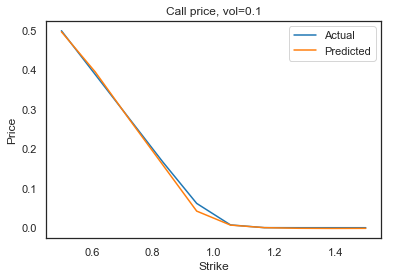

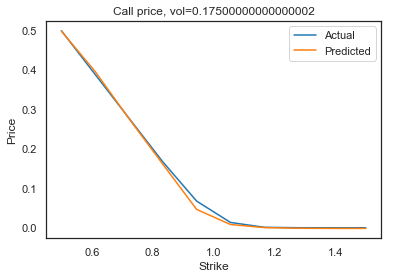

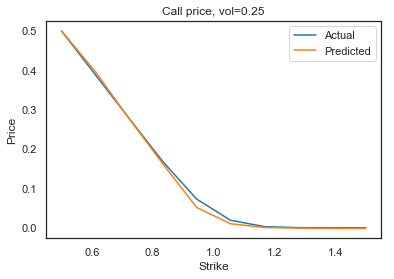

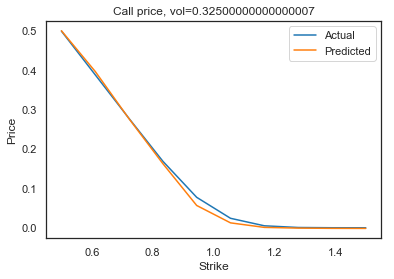

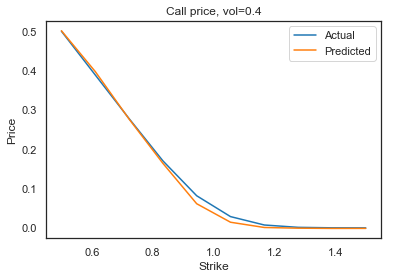

In [15]:
vols = np.linspace(0.1,0.4, 5)
model = create_model(layers, hidden_units, modelFile)
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
for i in range(5):
    f, strike, t, vol = [1], np.linspace(0.5, 1.5, 10), vols[i], [0.2]
    
    inputs = np.array(np.meshgrid(f, strike, t, vol)).T.reshape(-1, 4)
    prices = blackScholesPriceTrue(inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3])
    pred_prices = model.predict(inputs)
    plt.figure(i)
    plt.title("Call price, vol={}".format(vols[i]))
    plt.plot(strike, prices, label='Actual')
    plt.plot(strike, pred_prices, label='Predicted')
    plt.xlabel("Strike")
    plt.ylabel("Price")
    plt.legend()